# Intro<br>
This file is to apply Isolation Forest and PCA (unsupervised machine learning) to Hailong data that has been clustered based on <b>unique account ids (acount number + account name)</b> found in the journal documents. It is later saved in Account_cluster.xlsx 
<br><br>
The Inter-sheet Comparison section in this file is used to compare the results of the two clustering methods.
<br><br>
<b><u>Sections:</b></u>
<ul>
    <li><b>Import data and libraries</b></li>
    <li><b>Creating distinct account groups + JE IDs:</b> create 2 new columns (JE_Doc_ID & Account_ID) <br>
    JE_Doc_ID: journal document identifier<br>
    Account_ID: account identifier (Account number + cleaned Account name)
    </li>
    <li><b>Feature functions:</b> Functions to make feature columns</li>
    <li><b>JE Dataframe:</b><br> Apply functions to data to make feature columns. Journal documents where <u>all</u> its line entries are crediting/debiting 0 are removed.<br>
    2 dataframes made:<br>
    <ol>
        <li>Data + new feature columns in entry line format to use to make input dataframe</li>
        <li>Data + new feature columns grouped in journal document format (JE_Doc_ID) to use when saving results in journal document format</li>
    </ol>
    </li>
    <li><b>Feature Dataframe:</b> Create input dataframe (summary_df) to use in ML
    </li>
    <li><b>Isolation Forest:</b> Run Isolation Forest algorithm on input dataframe</li>
    <li><b>PCA:</b> Run PCA (Principal Component Analysis) algorithm on input dataframe</li>
    <li><b>Comparing:</b> Compare PCA and Isolation Forest anomaly results to see if both algorithms found the same anomalies.<br>If journal document is found anomalous in both algorithms, ISF_PCA_anomalies column = 1</li>
    <li><b>Saving:</b> Results saved into <u>Acc_cluster.xlsx</u>.<br>Sheets are edited to highlight feature columns and hide unnecessary columns.</li>
    <li><b>Inter-sheet Comparison:</b> Create a <u>new spreadsheet (Common_anomalies.xlsx)</u> which compares the results between the two different clustering methods</li>
    <li><b>Validate top 5 anomalies:</b> Create boxplot distributions of where top 5 anomalous journal documents are found in their respective clusters</li>
</ul>

<b>Key:</b><br>
{algo}<br>
ISF = Isolation Forest<br>
PCA = Principal Component Analysis<br>

{week} -> each specific week (Week1, Week2, Week3, Week4)
<br><br>
<b>Account_cluster.xlsx sheets:</b>
<ol>
    <li><b>{algo}_result_je:</b> Algorithm's result saved in journal document format</li>
    <li><b>{algo}_result_raw:</b> Algorithm's result saved in journal entry line format</li>
    <li><b>{algo}_cluster_metrics:</b> Cluster metrics found in Algorithm's result (biggest cluster at the top)</li><br>
        <ul>
        <li>Cluster_Population: Number of journal documents in the cluster</li>
        <li>Cluster_Anomalies: Number of anomalies found in the cluster</li>
        <li>ISF_PCA_Anomalies Count: Number of anomalies found by both Isolation Forest and PCA in the cluster</li>
        <li>Cluster_Population (%): Percentage of journal documents out of the total population found in the cluster</li>
        <li>Cluster_Population (%) - Cummulative: Cluster Population percentage accumulated down the sheet</li>
        <li>Percentage of anomalies in Cluster: Percentage of cluster that are anomalies</li>
        <li>Percentage of total anomalies in Cluster: Percentage of total anomalies found in cluster</li>
        <li>Unique_accounts: List of Unique accounts found in cluster</li>
        <li>Num_unique_accs: Number of unique accounts found in cluster</li>
        </ul>    
    <li><b>Cluster_Week_freq:</b> Breakdown of each cluster's week frequency and it's details</li>
        <ul>
        <li>{week}_je_count: Number of journal documents found in that week</li>
        <li>{week}_avg_days_in_week: Average number of days in that week across the months</li>
        <li>{week}_je_frequency: Journal documents made per day in that week (je_count ÷ avg_days)</li>
        <li>{week}_je_%_frequency: Percentage of journal documents made in that week across all weeks (je_frequency ÷ sum of je_frequency across all weeks)</li>
        </ul>
    <li><b>Input_df:</b> input dataframe saved (features_df)</li>
</ol>

# Import data and libraries

In [ ]:
%reload_ext autoreload
%autoreload 2

import sys
from importlib import reload
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import lime
import lime.lime_tabular
from tqdm import tqdm
import warnings

import _00_util_sql
reload(_00_util_sql)
from _00_util_sql import Conn_ODBC
from collections import Counter

In [39]:
##### Import data 
sql_db=Conn_ODBC(database="JE_ML_2025")         # Change to database
conn=sql_db.odbc_conn_db_pyodbc()
sql_query=f"SELECT * FROM data_Hailong_staging_JE_updated_All"
h_data=sql_db.odbc_run_sql(conn, sql_query, return_result=True)
conn.close()

h_data.info()
# 10 sec

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51977 entries, 0 to 51976
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   CompanyName                             51977 non-null  object 
 1   ExcludeBalanceOnly                      51977 non-null  object 
 2   PrintReversedEntries                    51977 non-null  object 
 3   PageGroupNo                             51977 non-null  int64  
 4   PrintOnlyOnePerPage                     51977 non-null  object 
 5   PrintClosingEntries                     51977 non-null  object 
 6   PrintOnlyCorrections                    51977 non-null  object 
 7   EmptyString                             0 non-null      object 
 8   No_GLAcc                                51977 non-null  object 
 9   DetailTrialBalCaption                   51977 non-null  object 
 10  PageCaption                             51977 non-null  ob

# Creating distinct account groups + JE IDs

In [40]:
# Cleaning Account name

import re
# Step 1: Normalize descriptions
def normalize_text(text):
    text = text.lower()
    # text = re.sub(r'\(.*?\)', '', text)  # Remove anything in parentheses
    # text = re.sub(r'[^a-z\s-]', '', text)  # Remove non-alphabetic characters
    # text = text.strip()

    # Fix typos / manual standardization
    text = text.replace('capatalization', 'capitalization')
    text = text.replace('(ntd)', '(twd)')
    return text

h_data['Normalized'] = h_data['Name_GLAcc'].apply(normalize_text)

# Step 2: Create distinct account labels
representative_labels = (
    h_data.groupby('No_GLAcc')['Normalized']
    .agg(lambda x: x.mode()[0])  # Choose most frequent normalized label
    .to_dict()
)

# Step 3: Merge clean labels back to dataset
h_data['Cleaned_NameGLAcc'] = h_data['No_GLAcc'].map(representative_labels)
h_data['Cleaned_NameGLAcc'].nunique()
# .to_excel(rf"d:\victoriaquek\JE ML 2025\Hailong\test.xlsx")

108

In [41]:
# Create distinct account labels (number + name)
h_data['Account_ID']=h_data['No_GLAcc'].astype(str)+' '+h_data['Cleaned_NameGLAcc'].str.lower()
# h_data['Account_ID'].value_counts().to_excel(rf"d:\victoriaquek\JE ML 2025\Hailong\test.xlsx")
h_data.drop(columns=['Normalized','Cleaned_NameGLAcc'], inplace=True)

# Count of number of distinct accounts
h_data['Account_ID'].nunique()

112

In [42]:
# Create unique JE IDs (Can be edited)
h_data['JE_Doc_ID'] = h_data['CompanyName'].astype(str) + '|' + h_data['DocumentNo_GLEntry'].astype(str) + '|' + h_data['PostingDate_GLEntry'].astype(str)
h_data['JE_Doc_ID'].nunique()

16973

# Feature functions
<ul>
<li><b>summarize_je_amounts():</b><br> Get the total credit and debit amounts for each unique journal entry </li>
<li><b>num_lines_je():</b><br> Get the number of entry lines for each unique journal entry </li>
<li><b>get_week_of_month_4week_smart_merge()</b>: <br> Assign each journal entry to a week in the month where a month is stipulated to have 4 weeks </li>
<li><b>get_weekly_je_frequency_by_account():</b><br> Compute the count and frequency (proportion) of Journal Entries (JE_Doc_ID) per WeekOfMonth (1-4) for each Account_ID (Cluster)</li>
<li><b>trailing_zeros():</b><br>Get number of trailing 0s in input number</li>


</ul>

In [43]:
def summarize_je_amounts(df_in):
    """
    Summarizes Credit and Debit amounts for each JE_Doc_ID.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'JE_Doc_ID', 'CreditAmount_GLEntry', and 'DebitAmount_GLEntry' columns.

    Returns:
    pd.DataFrame: A new DataFrame with JE_Doc_ID, total Credit, and total Debit.
    """

    df = df_in.copy()

    # Take absolute values before grouping
    df['CreditAmount_GLEntry'] = df['CreditAmount_GLEntry'].abs()
    df['DebitAmount_GLEntry'] = df['DebitAmount_GLEntry'].abs()

    summary = df.groupby('JE_Doc_ID').agg({
        'CreditAmount_GLEntry': 'sum',
        'DebitAmount_GLEntry': 'sum'
    }).reset_index()

    summary.rename(columns={
        'CreditAmount_GLEntry': 'Total_Credit',
        'DebitAmount_GLEntry': 'Total_Debit'
    }, inplace=True)

    # Compute Total_JE_Amount using row-wise logic
    summary['Total_JE_Amount'] = summary.apply(
        lambda row: row['Total_Credit'] if row['Total_Credit'] == row['Total_Debit']
        else max(row['Total_Credit'], row['Total_Debit']),
        # else np.nan,
        axis=1
    )

    return summary

In [44]:
# Testing
test=h_data.copy()
test = summarize_je_amounts(test)

nan_counts = test.isnull().sum()
print("NaN counts per column:\n", nan_counts,"\n")

rows_with_nans = test[test.isnull().any(axis=1)]
print("Rows with NaNs:\n", rows_with_nans)

# test['Total_JE_Amount']

NaN counts per column:
 JE_Doc_ID          0
Total_Credit       0
Total_Debit        0
Total_JE_Amount    0
dtype: int64 

Rows with NaNs:
 Empty DataFrame
Columns: [JE_Doc_ID, Total_Credit, Total_Debit, Total_JE_Amount]
Index: []


In [45]:
def num_lines_je(df_in):
    df = df_in.copy()
    # Calculate the number of lines per JE_Doc_ID
    line_counts = df.groupby('JE_Doc_ID').size().rename('num_lines_je')
    
    # Map the count back to each row in the original DataFrame
    df = df.copy()
    df['num_lines_je'] = df['JE_Doc_ID'].map(line_counts)
    
    return df

In [46]:
test=h_data.copy()
test=num_lines_je(test)

# Check if num_lines_je for all rows of the JE are the same
uniform_check = test.groupby('JE_Doc_ID')['num_lines_je'].nunique().reset_index()
uniform_check['is_uniform'] = uniform_check['num_lines_je'] == 1
uniform_check['is_uniform'].value_counts()

is_uniform
True    16973
Name: count, dtype: int64

## Week assignment

In [47]:
def get_week_of_month_4week_smart_merge(date):
    dt = pd.to_datetime(date)
    year, month = dt.year, dt.month

    # Generate all dates in the month
    start_of_month = dt.replace(day=1)
    if month == 12:
        end_of_month = dt.replace(year=year + 1, month=1, day=1) - pd.Timedelta(days=1)
    else:
        end_of_month = dt.replace(month=month + 1, day=1) - pd.Timedelta(days=1)

    dates_in_month = pd.date_range(start=start_of_month, end=end_of_month, freq='D')

    # --- GET MONDAY AS WEEK START USING 'W-MON' ---
    # 'W-MON' means: week starts Monday, ends Sunday
    # periods = pd.Series(dates_in_month).dt.to_period('W-MON')
    # monday_starts = periods.dt.start_time.dt.normalize()  # Each is a Monday
    monday_starts = pd.Series(dates_in_month).apply(lambda d: d - pd.Timedelta(days=d.weekday()))
    # print(monday_starts)

    # Group days in month by their Monday week start
    week_groups = {}
    for d, ws in zip(dates_in_month, monday_starts):
        if ws not in week_groups:
            week_groups[ws] = []
        week_groups[ws].append(d.day)
    # print(week_groups)

    # Now sort the unique Monday starts
    sorted_week_starts = sorted(week_groups.keys())  # These are all Mondays
    # print(sorted_week_starts)

    n_weeks = len(sorted_week_starts)

    # For debugging: print them
    # print("Sorted Monday week starts:", sorted_week_starts)

    # Final assignment: Monday start → (week_num, days_in_merged_week)
    assignment = {}

    if n_weeks == 4:
        for i, ws in enumerate(sorted_week_starts):
            assignment[ws] = (i + 1, len(week_groups[ws]))

    elif n_weeks == 5:
        first_len = len(week_groups[sorted_week_starts[0]])
        last_len = len(week_groups[sorted_week_starts[-1]])

        if first_len <= last_len:  # Merge first into second → Week 1
            w1_days = first_len + len(week_groups[sorted_week_starts[1]])
            assignment[sorted_week_starts[0]] = (1, w1_days)
            assignment[sorted_week_starts[1]] = (1, w1_days)
            assignment[sorted_week_starts[2]] = (2, len(week_groups[sorted_week_starts[2]]))
            assignment[sorted_week_starts[3]] = (3, len(week_groups[sorted_week_starts[3]]))
            assignment[sorted_week_starts[4]] = (4, len(week_groups[sorted_week_starts[4]]))
        else:  # Merge last into fourth → Week 4
            w4_days = len(week_groups[sorted_week_starts[3]]) + last_len
            assignment[sorted_week_starts[0]] = (1, len(week_groups[sorted_week_starts[0]]))
            assignment[sorted_week_starts[1]] = (2, len(week_groups[sorted_week_starts[1]]))
            assignment[sorted_week_starts[2]] = (3, len(week_groups[sorted_week_starts[2]]))
            assignment[sorted_week_starts[3]] = (4, w4_days)
            assignment[sorted_week_starts[4]] = (4, w4_days)

    elif n_weeks == 6:
        # Fold: W1→W2 → Week 1; W6→W5 → Week 4
        w1_days = len(week_groups[sorted_week_starts[0]]) + len(week_groups[sorted_week_starts[1]])
        w4_days = len(week_groups[sorted_week_starts[4]]) + len(week_groups[sorted_week_starts[5]])
        
        assignment[sorted_week_starts[0]] = (1, w1_days)
        assignment[sorted_week_starts[1]] = (1, w1_days)
        assignment[sorted_week_starts[2]] = (2, len(week_groups[sorted_week_starts[2]]))  # W3 → Week 2
        assignment[sorted_week_starts[3]] = (3, len(week_groups[sorted_week_starts[3]]))  # W4 → Week 3
        assignment[sorted_week_starts[4]] = (4, w4_days)
        assignment[sorted_week_starts[5]] = (4, w4_days)

    else:
        # Fallback
        total_days = len(dates_in_month)
        sizes = [total_days // 4 + (1 if i < total_days % 4 else 0) for i in range(4)]
        for i, ws in enumerate(sorted_week_starts):
            bucket = min(i, 3)
            assignment[ws] = (bucket + 1, sizes[bucket])

    # Find input date's Monday week start
    # print(assignment)
    # input_monday = dt.to_period('W-MON').start_time.normalize()
    input_monday = dt - pd.Timedelta(days=dt.weekday())
    week_num, days_in_week = assignment.get(input_monday, (4, 7))

    return {
        'week_of_month': week_num,
        'days_in_week': days_in_week
    }

In [48]:
def get_weekly_je_frequency_by_account(df):
    """
    For each Account_ID, compute the count and frequency (proportion) of 
    Journal Entries (JE_Doc_ID) per WeekOfMonth (1-4), based on PostingDate.
    Frequency is normalized by Days_in_week to account for variable week lengths.

    Parameters:
    df (pd.DataFrame): Must contain:
                       - 'Account_ID'
                       - 'JE_Doc_ID'
                       - 'PostingDate_GLEntry'

    Returns:
    tuple: 
        - long_df (pd.DataFrame): [Account_ID, WeekOfMonth, je_count, avg_days_in_week,
                                   je_frequency, je_%_frequency]
        - wide_df (pd.DataFrame): Pivoted version with columns like 
                                  Week1_je_count, Week1_je_%_frequency, etc.
    """
    # Make a copy and ensure datetime
    df = df.copy()
    df['PostingDate_GLEntry'] = pd.to_datetime(df['PostingDate_GLEntry'])

    # Extract WeekOfMonth and Days_in_week using helper function
    week_info = df['PostingDate_GLEntry'].apply(get_week_of_month_4week_smart_merge)
    df['WeekOfMonth'] = week_info.apply(lambda x: x['week_of_month'])
    df['Days_in_week'] = week_info.apply(lambda x: x['days_in_week'])

    # Drop duplicate JE_Doc_ID within same Account_ID (in case one JE has multiple rows)
    je_week = df[['Account_ID', 'JE_Doc_ID', 'WeekOfMonth', 'Days_in_week']].drop_duplicates(
        subset=['Account_ID', 'JE_Doc_ID']
    )

    # Group by Account_ID and WeekOfMonth to get counts and average days in week
    weekly_counts = (
        je_week.groupby(['Account_ID', 'WeekOfMonth'])
        .agg(
            je_count=('JE_Doc_ID', 'count'),
            avg_days_in_week=('Days_in_week', 'mean')  # Should be constant per week, but safe to avg
        )
        .reset_index()
    )

    # Compute raw frequency: JE count divided by number of days in that week
    weekly_counts['je_frequency'] = weekly_counts['je_count'] / weekly_counts['avg_days_in_week']

    # Total normalized frequency per Account_ID
    total_freq_per_account = (
        weekly_counts.groupby('Account_ID')['je_frequency'].sum()
        .reset_index(name='total_je_frequency')
    )

    # Merge back to compute percentage share
    weekly_counts = weekly_counts.merge(total_freq_per_account, on='Account_ID')
    weekly_counts['je_%_frequency'] = (weekly_counts['je_frequency'] / weekly_counts['total_je_frequency']) * 100

    # Drop helper column
    weekly_counts = weekly_counts.drop(columns=['total_je_frequency'])

    # Pivot to wide format
    pivot_cols = ['je_count', 'avg_days_in_week', 'je_frequency', 'je_%_frequency']
    pivot_df = weekly_counts.pivot(
        index='Account_ID',
        columns='WeekOfMonth',
        values=pivot_cols
    )

    # Flatten column multi-index
    pivot_df.columns = [
        f"Week{int(week)}_{metric}" 
        for metric, week in pivot_df.columns
    ]
    pivot_df = pivot_df.reset_index()

    # Fill NaNs (missing weeks) with 0
    pivot_df = pivot_df.fillna(0)

    return weekly_counts, pivot_df

In [49]:
def add_infrequent_week_flag(df):
    """
    Adds a column 'infrequent_w' to the DataFrame based on:
    1. If total je_count in a Account_ID <= 10 → infrequent_w = 0 (flag as low volume)
    2. Else:
        - Find weeks where je_%_frequency < 50%
        - But if any week has je_%_frequency >= 50%, then all *other* weeks are marked infrequent_w = 1
          (i.e., only the high-frequency week is considered frequent)
        - Weeks with >=50% get infrequent_w = 0, others = 1
       If no week reaches 50%, then all weeks get infrequent_w = 0 (no strong dominant week)

    Parameters:
        df (pd.DataFrame): Must have columns: 
                          ['Account_ID', 'WeekOfMonth', 'je_count', 'je_%_frequency']

    Returns:
        pd.DataFrame: Original DataFrame with added 'infrequent_w' column.
    """
    df = df.copy()  # Avoid modifying the original
    df['infrequent_w'] = 0  # Initialize

    # Group by Account_ID to evaluate each pattern
    for cluster, group in df.groupby('Account_ID'):
        total_je_count = group['je_count'].sum()

        # Rule 1: If total je_count <= 10, mark all rows in this cluster as 0
        if total_je_count <= 10:
            df.loc[df['Account_ID'] == cluster, 'infrequent_w'] = 0
            continue

        # Rule 2: Check for weeks with je_%_frequency >= 50%
        high_freq_mask = group['je_%_frequency'] >= 50

        if high_freq_mask.any():
            # Mark all weeks NOT having >=50% as infrequent (1), others as frequent (0)
            cluster_indices = group.index
            df.loc[cluster_indices, 'infrequent_w'] = 1  # default to infrequent
            df.loc[cluster_indices[high_freq_mask], 'infrequent_w'] = 0  # except high-freq ones
        else:
            # No week has >=50%, so no week is flagged as infrequent
            df.loc[df['Account_ID'] == cluster, 'infrequent_w'] = 0

    return df

In [50]:
test=h_data.copy()
test, test2 = get_weekly_je_frequency_by_account(test)

In [51]:
test

,Account_ID,WeekOfMonth,je_count,avg_days_in_week,je_frequency,je_%_frequency
0,10000000 cash on hands - twd,1,1010,10.493069,96.254010,18.877480
1,10000000 cash on hands - twd,2,1080,7.000000,154.285714,30.258744
2,10000000 cash on hands - twd,3,691,7.000000,98.714286,19.359993
3,10000000 cash on hands - twd,4,1354,8.429099,160.634014,31.503782
4,10000010 cash on hands - usd,1,208,10.115385,20.562738,19.199127
...,...,...,...,...,...,...
292,70010100 unrealized exchange gain/loss,3,16,7.000000,2.285714,9.721691
293,70010100 unrealized exchange gain/loss,4,85,7.011765,12.122483,51.559828
294,70100000 gain/loss on sale of assets,3,3,7.000000,0.428571,61.643836
295,70100000 gain/loss on sale of assets,4,2,7.500000,0.266667,38.356164


In [52]:
test2

,Account_ID,Week1_je_count,Week2_je_count,Week3_je_count,Week4_je_count,Week1_avg_days_in_week,Week2_avg_days_in_week,Week3_avg_days_in_week,Week4_avg_days_in_week,Week1_je_frequency,Week2_je_frequency,Week3_je_frequency,Week4_je_frequency,Week1_je_%_frequency,Week2_je_%_frequency,Week3_je_%_frequency,Week4_je_%_frequency
0,10000000 cash on hands - twd,1010.0,1080.0,691.0,1354.0,10.493069,7.0,7.0,8.429099,96.254010,154.285714,98.714286,160.634014,18.877480,30.258744,19.359993,31.503782
1,10000010 cash on hands - usd,208.0,187.0,146.0,327.0,10.115385,7.0,7.0,8.391437,20.562738,26.714286,20.857143,38.968294,19.199127,24.942738,19.474009,36.384126
2,10000020 cash on hands - eur,215.0,199.0,190.0,367.0,9.795349,7.0,7.0,8.618529,21.949193,28.428571,27.142857,42.582675,18.275263,23.670101,22.599594,35.455043
3,10000045 cash on hands - jpy,0.0,0.0,6.0,27.0,0.000000,0.0,7.0,7.296296,0.000000,0.000000,0.857143,3.700508,0.000000,0.000000,18.806683,81.193317
4,10000050 time deposit - twd,0.0,0.0,2.0,2.0,0.000000,0.0,7.0,5.000000,0.000000,0.000000,0.285714,0.400000,0.000000,0.000000,41.666667,58.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,60900200 cost capitalization,0.0,0.0,0.0,27.0,0.000000,0.0,0.0,7.666667,0.000000,0.000000,0.000000,3.521739,0.000000,0.000000,0.000000,100.000000
108,70010000 foreign exchange gain/loss,289.0,307.0,232.0,578.0,10.134948,7.0,7.0,8.553633,28.515193,43.857143,33.142857,67.573625,16.474313,25.337941,19.147890,39.039856
109,70010100 unrealized exchange gain/loss,43.0,32.0,16.0,85.0,9.488372,7.0,7.0,7.011765,4.531863,4.571429,2.285714,12.122483,19.275099,19.443382,9.721691,51.559828
110,70100000 gain/loss on sale of assets,0.0,0.0,3.0,2.0,0.000000,0.0,7.0,7.500000,0.000000,0.000000,0.428571,0.266667,0.000000,0.000000,61.643836,38.356164


## Trailing 0s

In [53]:
def trailing_zeros(n):
    # Convert to string and split at decimal
    whole_part = str(int(float(n)))  # Remove decimal and convert to int
    count = 0
    for digit in reversed(whole_part):
        if digit == '0':
            count += 1
        else:
            break
    return count

## Benford's law

In [54]:
def benford_probability(d):
    d=int(d)
    if d == 0:
        return 0
    return np.log10(1 + 1 / d)*100

benford_probability(10)

np.float64(4.139268515822508)

In [55]:
def leading_digit_frequency_no_group(df, value_cols):
    """
    Computes the frequency of the first two leading digits from rows where
    exactly one of the columns in `value_cols` is non-zero.
    No grouping is applied.

    Parameters:
    - df: pandas DataFrame
    - value_cols: list of two column names to check

    Returns:
    - A DataFrame with leading digits and their overall frequency
    """
    col1, col2 = value_cols

    # Identify rows where both columns are non-zero
    both_non_zero = df[(df[col1] != 0) & (df[col2] != 0)]
    if not both_non_zero.empty:
        print("⚠️ Warning: Found rows where both columns are non-zero:")
        print(both_non_zero[[col1, col2]])

    # Filter rows where exactly one column is non-zero
    df = df[((df[col1] != 0) & (df[col2] == 0)) | ((df[col1] == 0) & (df[col2] != 0))].copy()

    # Create a column with the non-zero value
    df['combined_value'] = df.apply(lambda row: row[col1] if row[col1] != 0 else row[col2], axis=1)

    # Extract first two digits
    df['leading_digits'] = df['combined_value'].astype(str).str.replace(r'\D', '', regex=True).str[:2]

    # Filter out invalid or short digit strings and exclude '00'
    df = df[df['leading_digits'].str.len() == 2]
    df = df[df['leading_digits'] != '00']

    # Count and normalize frequencies
    freq_df = df['leading_digits'].value_counts(normalize=True).reset_index()
    freq_df.columns = ['leading_digits', 'actual_frequency']
    freq_df['actual_frequency'] *= 100  # Convert to percentage
    freq_df['benford_p'] = freq_df['leading_digits'].apply(benford_probability)

    N = len(df)  # Total number of valid observations
    # print(N)
    # Calculate z-score
    freq_df['z_score'] = freq_df.apply(
        lambda row: (
            ((row['actual_frequency'] / 100) - (row['benford_p'] / 100)) /
            np.sqrt((row['benford_p'] / 100 * (1 - row['benford_p'] / 100)) / N)
            if pd.notnull(row['benford_p']) and N > 0 else np.nan
        ),
        axis=1
    )

    return freq_df.sort_values(by='leading_digits', ascending=True)

# JE Dataframe

In [56]:
je_df = h_data.copy()

je_amts = summarize_je_amounts(je_df)
je_df = je_df.merge(je_amts, on='JE_Doc_ID', how='left')

je_df = je_df[je_df['Total_JE_Amount'] != 0].copy()
je_df['JE_Doc_ID'].nunique()

16955

In [57]:
je_df = num_lines_je(je_df)
je_df

,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,DetailTrialBalCaption,...,GL_Acc_Category,UT_unusual_pairing,UT_dr_cr_liability,UT_dr_liability_cr_income_exp,Account_ID,JE_Doc_ID,Total_Credit,Total_Debit,Total_JE_Amount,num_lines_je
0,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,Assets,0,0,0,16100000 construction in progress,Hailong2|GJ24050619|2024-05-14,124788.0,124788.0,124788.0,2
1,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,Assets,0,0,0,16100000 construction in progress,Hailong2|GJ24050620|2024-05-14,6885.0,6885.0,6885.0,2
2,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,Assets,0,0,0,16100000 construction in progress,Hailong2|GJ24050621|2024-05-14,6615.0,6615.0,6615.0,3
3,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,Assets,0,0,0,16100000 construction in progress,Hailong2|GJ24050622|2024-05-14,343369.0,343369.0,343369.0,2
4,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,Assets,0,0,0,16100000 construction in progress,Hailong2|GJ24050624|2024-05-14,329904.0,329904.0,329904.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51972,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,Liabilities,0,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,121215698.0,121215698.0,121215698.0,51
51973,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,Liabilities,0,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,121215698.0,121215698.0,121215698.0,51
51974,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,Liabilities,0,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,121215698.0,121215698.0,121215698.0,51
51975,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,Liabilities,0,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,121215698.0,121215698.0,121215698.0,51


In [58]:
je_df['WeekOfMonth'] = je_df['PostingDate_GLEntry'].apply(lambda x: get_week_of_month_4week_smart_merge(x)['week_of_month'])
je_df['Days_in_week'] = je_df['PostingDate_GLEntry'].apply(lambda x: get_week_of_month_4week_smart_merge(x)['days_in_week'])
je_df

,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,DetailTrialBalCaption,...,UT_dr_cr_liability,UT_dr_liability_cr_income_exp,Account_ID,JE_Doc_ID,Total_Credit,Total_Debit,Total_JE_Amount,num_lines_je,WeekOfMonth,Days_in_week
0,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,0,16100000 construction in progress,Hailong2|GJ24050619|2024-05-14,124788.0,124788.0,124788.0,2,2,7
1,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,0,16100000 construction in progress,Hailong2|GJ24050620|2024-05-14,6885.0,6885.0,6885.0,2,2,7
2,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,0,16100000 construction in progress,Hailong2|GJ24050621|2024-05-14,6615.0,6615.0,6615.0,3,2,7
3,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,0,16100000 construction in progress,Hailong2|GJ24050622|2024-05-14,343369.0,343369.0,343369.0,2,2,7
4,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,0,16100000 construction in progress,Hailong2|GJ24050624|2024-05-14,329904.0,329904.0,329904.0,3,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51972,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,121215698.0,121215698.0,121215698.0,51,4,7
51973,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,121215698.0,121215698.0,121215698.0,51,4,7
51974,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,121215698.0,121215698.0,121215698.0,51,4,7
51975,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,0,20000000 ap - trade,Hailong3|FX202312 FXEV|2023-12-31,121215698.0,121215698.0,121215698.0,51,4,7


In [59]:
time_df, save_df = get_weekly_je_frequency_by_account(je_df)
time_df

,Account_ID,WeekOfMonth,je_count,avg_days_in_week,je_frequency,je_%_frequency
0,10000000 cash on hands - twd,1,1010,10.493069,96.254010,18.882771
1,10000000 cash on hands - twd,2,1079,7.000000,154.142857,30.239199
2,10000000 cash on hands - twd,3,691,7.000000,98.714286,19.365419
3,10000000 cash on hands - twd,4,1354,8.429099,160.634014,31.512611
4,10000010 cash on hands - usd,1,208,10.115385,20.562738,19.199127
...,...,...,...,...,...,...
290,70010100 unrealized exchange gain/loss,3,16,7.000000,2.285714,9.981489
291,70010100 unrealized exchange gain/loss,4,81,7.037037,11.510526,50.265334
292,70100000 gain/loss on sale of assets,3,3,7.000000,0.428571,77.419355
293,70100000 gain/loss on sale of assets,4,1,8.000000,0.125000,22.580645


In [60]:
save_df.head(5)

,Account_ID,Week1_je_count,Week2_je_count,Week3_je_count,Week4_je_count,Week1_avg_days_in_week,Week2_avg_days_in_week,Week3_avg_days_in_week,Week4_avg_days_in_week,Week1_je_frequency,Week2_je_frequency,Week3_je_frequency,Week4_je_frequency,Week1_je_%_frequency,Week2_je_%_frequency,Week3_je_%_frequency,Week4_je_%_frequency
0,10000000 cash on hands - twd,1010.0,1079.0,691.0,1354.0,10.493069,7.0,7.0,8.429099,96.254010,154.142857,98.714286,160.634014,18.882771,30.239199,19.365419,31.512611
1,10000010 cash on hands - usd,208.0,187.0,146.0,327.0,10.115385,7.0,7.0,8.391437,20.562738,26.714286,20.857143,38.968294,19.199127,24.942738,19.474009,36.384126
2,10000020 cash on hands - eur,215.0,199.0,190.0,367.0,9.795349,7.0,7.0,8.618529,21.949193,28.428571,27.142857,42.582675,18.275263,23.670101,22.599594,35.455043
3,10000045 cash on hands - jpy,0.0,0.0,6.0,27.0,0.000000,0.0,7.0,7.296296,0.000000,0.000000,0.857143,3.700508,0.000000,0.000000,18.806683,81.193317
4,10000050 time deposit - twd,0.0,0.0,2.0,2.0,0.000000,0.0,7.0,5.000000,0.000000,0.000000,0.285714,0.400000,0.000000,0.000000,41.666667,58.333333


In [61]:
to_insert = add_infrequent_week_flag(time_df)
to_insert

,Account_ID,WeekOfMonth,je_count,avg_days_in_week,je_frequency,je_%_frequency,infrequent_w
0,10000000 cash on hands - twd,1,1010,10.493069,96.254010,18.882771,0
1,10000000 cash on hands - twd,2,1079,7.000000,154.142857,30.239199,0
2,10000000 cash on hands - twd,3,691,7.000000,98.714286,19.365419,0
3,10000000 cash on hands - twd,4,1354,8.429099,160.634014,31.512611,0
4,10000010 cash on hands - usd,1,208,10.115385,20.562738,19.199127,0
...,...,...,...,...,...,...,...
290,70010100 unrealized exchange gain/loss,3,16,7.000000,2.285714,9.981489,1
291,70010100 unrealized exchange gain/loss,4,81,7.037037,11.510526,50.265334,0
292,70100000 gain/loss on sale of assets,3,3,7.000000,0.428571,77.419355,0
293,70100000 gain/loss on sale of assets,4,1,8.000000,0.125000,22.580645,0


In [62]:
to_insert[to_insert["Account_ID"]=="10000052 time deposit - eur"]
# to_insert[to_insert["infrequent_w"]==1]

,Account_ID,WeekOfMonth,je_count,avg_days_in_week,je_frequency,je_%_frequency,infrequent_w
18,10000052 time deposit - eur,1,2,9.0,0.222222,11.914894,1
19,10000052 time deposit - eur,2,1,7.0,0.142857,7.659574,1
20,10000052 time deposit - eur,4,9,6.0,1.500000,80.425532,0


In [63]:
feature_df = je_df.merge(
    to_insert[['Account_ID', 'WeekOfMonth', 'avg_days_in_week','je_frequency', 'je_%_frequency', 'infrequent_w']],
    on=['Account_ID', 'WeekOfMonth'],
    how="left"
)
feature_df

,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,DetailTrialBalCaption,...,Total_Credit,Total_Debit,Total_JE_Amount,num_lines_je,WeekOfMonth,Days_in_week,avg_days_in_week,je_frequency,je_%_frequency,infrequent_w
0,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,124788.0,124788.0,124788.0,2,2,7,7.000000,217.000000,24.846060,0
1,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,6885.0,6885.0,6885.0,2,2,7,7.000000,217.000000,24.846060,0
2,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,6615.0,6615.0,6615.0,3,2,7,7.000000,217.000000,24.846060,0
3,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,343369.0,343369.0,343369.0,2,2,7,7.000000,217.000000,24.846060,0
4,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,329904.0,329904.0,329904.0,3,2,7,7.000000,217.000000,24.846060,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51675,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,121215698.0,121215698.0,121215698.0,51,4,7,8.640222,417.234654,28.906493,0
51676,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,121215698.0,121215698.0,121215698.0,51,4,7,8.640222,417.234654,28.906493,0
51677,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,121215698.0,121215698.0,121215698.0,51,4,7,8.640222,417.234654,28.906493,0
51678,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,121215698.0,121215698.0,121215698.0,51,4,7,8.640222,417.234654,28.906493,0


In [64]:
feature_df['acc_amt_je_line']=feature_df.apply(lambda row: row['DebitAmount_GLEntry'] if row['DebitAmount_GLEntry'] != 0 else -row['CreditAmount_GLEntry'], axis=1)
feature_df[feature_df['acc_amt_je_line']<0][['DebitAmount_GLEntry','CreditAmount_GLEntry', 'acc_amt_je_line']]

,DebitAmount_GLEntry,CreditAmount_GLEntry,acc_amt_je_line
82,0.0,4467707.0,-4467707.0
156,0.0,438384.0,-438384.0
157,0.0,1206429.0,-1206429.0
181,0.0,2932137.0,-2932137.0
182,0.0,2817152.0,-2817152.0
...,...,...,...
51668,0.0,131659.0,-131659.0
51670,0.0,34802.0,-34802.0
51672,0.0,59662.0,-59662.0
51674,0.0,347.0,-347.0


In [65]:
feature_df['Amt_trailing0s'] = feature_df['acc_amt_je_line'].apply(trailing_zeros)
feature_df[feature_df['Amt_trailing0s']!=0][['Amt_trailing0s', 'acc_amt_je_line']]

,Amt_trailing0s,acc_amt_je_line
9,5,200000.0
17,3,6000.0
18,3,6000.0
22,1,1149050.0
25,1,8160.0
...,...,...
51655,1,-43580.0
51657,1,-8424570.0
51666,1,-234940.0
51669,1,3950.0


In [66]:
# ben_pop = leading_digit_frequency_no_group(feature_df, ['DebitAmount_GLEntry', 'CreditAmount_GLEntry'])
# feature_2_df = feature_df.copy()
# feature_2_df['leading_digits'] = feature_2_df['acc_amt_je_line'].astype(str).str.replace(r'\D', '', regex=True).str[:2]
# feature_2_df['leading_digits'].unique()

In [67]:
# ben_pop['z_score'].unique()

In [68]:
# feature_3_df = feature_2_df.merge(ben_pop, on='leading_digits', how='left')
# feature_3_df[feature_3_df['z_score'].isna()]

In [69]:
# feature_df['infrequent_w'].unique()
grouped_df = feature_df.groupby('JE_Doc_ID').agg(lambda x: list(x)).reset_index()
grouped_df

,JE_Doc_ID,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,...,Total_JE_Amount,num_lines_je,WeekOfMonth,Days_in_week,avg_days_in_week,je_frequency,je_%_frequency,infrequent_w,acc_amt_je_line,Amt_trailing0s
0,Hailong2|EX20221025|2022-10-25,"[Hailong2, Hailong2]","[FALSE, FALSE]","[FALSE, FALSE]","[1, 1]","[FALSE, FALSE]","[FALSE, FALSE]","[FALSE, FALSE]","[None, None]","[10000020, 70010000]",...,"[1.0, 1.0]","[2, 2]","[4, 4]","[8, 8]","[8.618528610354224, 8.559027777777779]","[42.58267467594056, 67.2973630831643]","[35.455042520515995, 38.94240363545439]","[0, 0]","[1.0, -1.0]","[0, 0]"
1,Hailong2|FX20221101|2022-11-29,"[Hailong2, Hailong2, Hailong2, Hailong2]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[1, 1, 1, 1]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[None, None, None, None]","[10000020, 10000020, 70010000, 70010000]",...,"[4087160141.0, 4087160141.0, 4087160141.0, 408...","[4, 4, 4, 4]","[4, 4, 4, 4]","[10, 10, 10, 10]","[8.618528610354224, 8.618528610354224, 8.55902...","[42.58267467594056, 42.58267467594056, 67.2973...","[35.455042520515995, 35.455042520515995, 38.94...","[0, 0, 0, 0]","[2060999820.0, -2026160321.0, -2060999820.0, 2...","[1, 0, 1, 0]"
2,Hailong2|FX20221104|2022-11-30,"[Hailong2, Hailong2, Hailong2, Hailong2]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[1, 1, 1, 1]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[None, None, None, None]","[10000010, 10000010, 70010000, 70010000]",...,"[93484494714.0, 93484494714.0, 93484494714.0, ...","[4, 4, 4, 4]","[4, 4, 4, 4]","[10, 10, 10, 10]","[8.391437308868502, 8.391437308868502, 8.55902...","[38.968294460641395, 38.968294460641395, 67.29...","[36.38412620510666, 36.38412620510666, 38.9424...","[0, 0, 0, 0]","[46742247357.0, -46742247357.0, -46742247357.0...","[0, 0, 0, 0]"
3,Hailong2|FX20221201|2022-12-24,"[Hailong2, Hailong2]","[FALSE, FALSE]","[FALSE, FALSE]","[1, 1]","[FALSE, FALSE]","[FALSE, FALSE]","[FALSE, FALSE]","[None, None]","[10000020, 70010000]",...,"[17505373.0, 17505373.0]","[2, 2]","[3, 3]","[7, 7]","[7.0, 7.0]","[27.142857142857142, 33.142857142857146]","[22.599593883002957, 19.178500632994773]","[0, 0]","[17505373.0, -17505373.0]","[0, 0]"
4,Hailong2|FX20221202|2022-12-24,"[Hailong2, Hailong2, Hailong2, Hailong2]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[1, 1, 1, 1]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[None, None, None, None]","[10000010, 10000010, 70010000, 70010000]",...,"[35614941.0, 35614941.0, 35614941.0, 35614941.0]","[4, 4, 4, 4]","[3, 3, 3, 3]","[7, 7, 7, 7]","[7.0, 7.0, 7.0, 7.0]","[20.857142857142858, 20.857142857142858, 33.14...","[19.474009024405582, 19.474009024405582, 19.17...","[0, 0, 0, 0]","[-17814966.0, 17799975.0, 17814966.0, -1779997...","[0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16950,Hailong3|GJ24050528|2024-05-31,"[Hailong3, Hailong3]","[FALSE, FALSE]","[FALSE, FALSE]","[1, 1]","[FALSE, FALSE]","[FALSE, FALSE]","[FALSE, FALSE]","[None, None]","[2002YECL, 16100000]",...,"[12786275.0, 12786275.0]","[2, 2]","[4, 4]","[5, 5]","[7.72093023255814, 8.417260159195642]","[11.138554216867469, 283.5839637666733]","[74.99275740193522, 32.46978906825342]","[0, 0]","[12786275.0, -12786275.0]","[0, 0]"
16951,Hailong3|GJ24050529|2024-05-31,"[Hailong3, Hailong3, Hailong3, Hailong3]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[1, 1, 1, 1]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[FALSE, FALSE, FALSE, FALSE]","[None, None, None, None]","[20800000, 14020000, 30400000, 30400010]",...,"[950924673.0, 950924673.0, 950924673.0, 950924...","[4, 4, 4, 4]","[4, 4, 4, 4]","[5, 5, 5, 5]","[7.712121212121212, 7.857142857142857, 7.64705

In [70]:
def condense_uniform_lists(df):
    for col in df.columns:
        if col == 'JE_Doc_ID':
            continue  # Skip the grouping key
        df[col] = df[col].apply(lambda x: x[0] if len(set(x)) == 1 else x)
    return df

cleaned_df = condense_uniform_lists(grouped_df)
cleaned_df

,JE_Doc_ID,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,...,Total_JE_Amount,num_lines_je,WeekOfMonth,Days_in_week,avg_days_in_week,je_frequency,je_%_frequency,infrequent_w,acc_amt_je_line,Amt_trailing0s
0,Hailong2|EX20221025|2022-10-25,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000020, 70010000]",...,1.000000e+00,2,4,8,"[8.618528610354224, 8.559027777777779]","[42.58267467594056, 67.2973630831643]","[35.455042520515995, 38.94240363545439]",0,"[1.0, -1.0]",0
1,Hailong2|FX20221101|2022-11-29,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000020, 10000020, 70010000, 70010000]",...,4.087160e+09,4,4,10,"[8.618528610354224, 8.618528610354224, 8.55902...","[42.58267467594056, 42.58267467594056, 67.2973...","[35.455042520515995, 35.455042520515995, 38.94...",0,"[2060999820.0, -2026160321.0, -2060999820.0, 2...","[1, 0, 1, 0]"
2,Hailong2|FX20221104|2022-11-30,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000010, 10000010, 70010000, 70010000]",...,9.348449e+10,4,4,10,"[8.391437308868502, 8.391437308868502, 8.55902...","[38.968294460641395, 38.968294460641395, 67.29...","[36.38412620510666, 36.38412620510666, 38.9424...",0,"[46742247357.0, -46742247357.0, -46742247357.0...",0
3,Hailong2|FX20221201|2022-12-24,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000020, 70010000]",...,1.750537e+07,2,3,7,7.0,"[27.142857142857142, 33.142857142857146]","[22.599593883002957, 19.178500632994773]",0,"[17505373.0, -17505373.0]",0
4,Hailong2|FX20221202|2022-12-24,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000010, 10000010, 70010000, 70010000]",...,3.561494e+07,4,3,7,7.0,"[20.857142857142858, 20.857142857142858, 33.14...","[19.474009024405582, 19.474009024405582, 19.17...",0,"[-17814966.0, 17799975.0, 17814966.0, -1779997...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16950,Hailong3|GJ24050528|2024-05-31,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[2002YECL, 16100000]",...,1.278628e+07,2,4,5,"[7.72093023255814, 8.417260159195642]","[11.138554216867469, 283.5839637666733]","[74.99275740193522, 32.46978906825342]",0,"[12786275.0, -12786275.0]",0
16951,Hailong3|GJ24050529|2024-05-31,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[20800000, 14020000, 30400000, 30400010]",...,9.509247e+08,4,4,5,"[7.712121212121212, 7.857142857142857, 7.64705...","[8.55795677799607, 0.890909090909091, 4.446153...",100.0,0,"[158487446.0, -792437227.0, 792437227.0, -1584...",0
16952,Hailong3|GJ24050530|2024-05-31,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[20800000, 14020000, 30400000, 30400010]",...,9.996661e+08,4,4,5,"[7.712121212121212, 7.857142857142857, 7.64705...","[8.55795677799607, 0.890909090909091, 4.446153...",100.0,0,"[-166611020.0, 833055101.0, -833055101.0, 1666...","[1, 0, 0, 1]"
16953,Hailong3|GJ24050531|2024-05-31,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[2060EDBS, 2060EDBS-I, 2060EMUFG, 2060EMUFG-I,...",...,3.680016e+07,8,4,5,"[5.0, 7.153846153846154, 7.5, 7.63157894736842...","[0.4, 1.8172043010752688, 0.5333333333333333, ...","[36.84210526315789, 78.42227378190255, 30.5177...",0,"[-14228144.0, 14163877.0, -15454913.0, 1545491...",0


# Feature Dataframe

In [71]:
feature_df[feature_df['Account_ID']=='10000000 cash on hands - twd'][['WeekOfMonth','je_frequency','je_%_frequency','infrequent_w']].drop_duplicates().sort_values('WeekOfMonth')
# feature_df_2[feature_df_2['Account_ID']=='80100000 income taxes - deferred'][['WeekOfMonth','je_frequency']].drop_duplicates().sort_values('WeekOfMonth')

,WeekOfMonth,je_frequency,je_%_frequency,infrequent_w
3072,1,96.254010,18.882771,0
2522,2,154.142857,30.239199,0
2349,3,98.714286,19.365419,0
2761,4,160.634014,31.512611,0


In [72]:
# Select only the relevant columns
features = [
    'Total_JE_Amount', 'acc_amt_je_line',
    'num_lines_je', 'infrequent_w',
    'Amt_trailing0s'
]

# Ensure we have Account_ID, JE_Doc_ID, and all features
summary_df = feature_df[['Account_ID', 'JE_Doc_ID'] + features].copy()
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51680 entries, 0 to 51679
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Account_ID       51680 non-null  object 
 1   JE_Doc_ID        51680 non-null  object 
 2   Total_JE_Amount  51680 non-null  float64
 3   acc_amt_je_line  51680 non-null  float64
 4   num_lines_je     51680 non-null  int64  
 5   infrequent_w     51680 non-null  int64  
 6   Amt_trailing0s   51680 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 2.8+ MB


In [73]:
# Optional: Remove duplicate rows (if same Account-JE appears multiple times unnecessarily)
# summary_df.drop_duplicates(inplace=True)

# Sort for readability (optional)
summary_df.sort_values(by=['Account_ID', 'JE_Doc_ID'], inplace=True)
# summary_df['z_score'].unique()       # nan present for lines with 0
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51680 entries, 6356 to 42293
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Account_ID       51680 non-null  object 
 1   JE_Doc_ID        51680 non-null  object 
 2   Total_JE_Amount  51680 non-null  float64
 3   acc_amt_je_line  51680 non-null  float64
 4   num_lines_je     51680 non-null  int64  
 5   infrequent_w     51680 non-null  int64  
 6   Amt_trailing0s   51680 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 3.2+ MB


In [74]:
summary_df[summary_df['JE_Doc_ID']=='Hailong2|GJ24050924|2024-05-24']

,Account_ID,JE_Doc_ID,Total_JE_Amount,acc_amt_je_line,num_lines_je,infrequent_w,Amt_trailing0s
129,16100000 construction in progress,Hailong2|GJ24050924|2024-05-24,32063.0,1364.0,6,0,0
130,16100000 construction in progress,Hailong2|GJ24050924|2024-05-24,32063.0,3340.0,6,0,1
17500,20010010 ap - employee,Hailong2|GJ24050924|2024-05-24,32063.0,-32063.0,6,0,0
37890,60040030 travel - transportation,Hailong2|GJ24050924|2024-05-24,32063.0,20049.0,6,0,0
37956,60040050 travel - meal,Hailong2|GJ24050924|2024-05-24,32063.0,110.0,6,0,1
30990,60040180 training,Hailong2|GJ24050924|2024-05-24,32063.0,7200.0,6,0,2


# Isolation Forest<br>
10010001 (No_GLAcc) has 2 Name_GLAcc: Restricted Cash - Time Deposit(TWD) [7 count], Restricted Cash - Time Deposit(NTD) [4 count]<br>
60900200 (No_GLAcc) has 2 Name_GLAcc: Cost Capatalization [24 count], Cost Capitalization [4 count]<br>
Each account has it's own cluster so JEs could be repeated between clusters

In [75]:
def detect_anomalies_by_account_isf_clean(
    df: pd.DataFrame,
    feature_cols: list,
    thres: float = 0.025,
    use_shap: bool = True,
    use_lime: bool = False
) -> pd.DataFrame:
    """
    Detect anomalies per Account_ID using pre-engineered features.
    Uses Isolation Forest + SHAP/LIME for explanations.

    Parameters:
    -----------
    df : pd.DataFrame
        Must contain: 'Account_ID', 'JE_Doc_ID', and all columns in feature_cols
    feature_cols : list of str
        List of numeric feature names (e.g., ['Total_JE_Amount', ...])
    thres : float
        Contamination threshold for Isolation Forest (default 0.1 → 10% are anomalies)
    use_shap : bool
        Whether to compute SHAP values
    use_lime : bool
        Whether to use LIME (slow; recommended only for debugging)

    Returns:
    --------
    pd.DataFrame
        Original DataFrame with added:
        - 'is_anomaly': bool
        - 'anomaly_score': float
        - 'anomaly_reason': str (SHAP/LIME-based)

    Each line of JE for that account is given its own anomaly_score
    """
    
    # Suppress warnings
    warnings.filterwarnings("ignore", message="X does not have valid feature names", category=UserWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    result_df = df.copy().reset_index(drop=True)
    result_df['is_anomaly'] = False
    result_df['anomaly_score'] = np.nan
    result_df['anomaly_reason'] = ""

    grouped = result_df.groupby('Account_ID')
    print(f"Processing {len(grouped)} unique Account_IDs...")

    for account_id, group in tqdm(grouped, desc="Processing Accounts"):
        group_mask = result_df['Account_ID'] == account_id
        X = group[feature_cols].copy()

        # Drop rows where all features are NaN
        if X.isna().all(axis=1).all():
            result_df.loc[group_mask, 'anomaly_reason'] = "All features missing"
            continue

        # Fill NA if any (can adjust strategy)
        X.fillna(0, inplace=True)

        n_samples = len(X)
        if n_samples < 2:
            result_df.loc[group_mask, 'anomaly_reason'] = "Not enough transactions in account"
            result_df.loc[group_mask, 'is_anomaly'] = False
            result_df.loc[group_mask, 'anomaly_score'] = 0.0
            continue

        # --- Apply Isolation Forest ---
        iso_forest = IsolationForest(contamination=thres, random_state=42, n_estimators=100)
        try:
            iso_forest.fit(X.values)
            scores = iso_forest.decision_function(X.values)
            preds = iso_forest.predict(X.values)  # -1 = anomaly
        except Exception as e:
            print(f"Isolation Forest failed for Account_ID {account_id}: {e}")
            result_df.loc[group_mask, 'anomaly_reason'] = "Model fit error"
            result_df.loc[group_mask, 'anomaly_score'] = 0.0
            continue

        # Map back to original indices
        je_indices = group.index
        result_df.loc[je_indices, 'anomaly_score'] = scores
        result_df.loc[je_indices, 'is_anomaly'] = (preds == -1)

        # --- Explain using SHAP ---
        shap_values = None
        if use_shap:
            try:
                explainer = shap.TreeExplainer(iso_forest, feature_names=feature_cols)
                shap_raw = explainer.shap_values(X.values)
                shap_values = np.abs(shap_raw) if not isinstance(shap_raw, list) else np.abs(shap_raw[0])
            except Exception as e:
                print(f"SHAP failed for Account_ID {account_id}: {e}")

        # --- Optional: LIME setup ---
        lime_explainer = None
        if use_lime:
            try:
                def pred_fn(x):
                    return iso_forest.decision_function(x.reshape(-1, X.shape[1]) if x.ndim == 1 else x)
                
                lime_explainer = lime.lime_tabular.LimeTabularExplainer(
                    X.values,
                    feature_names=feature_cols,
                    class_names=['anomaly_score'],
                    mode='regression',
                    random_state=42
                )
            except Exception as e:
                print(f"LIME setup failed for Account_ID {account_id}: {e}")

        # --- Generate Explanations ---
        for idx in range(len(group)):
            row_idx = je_indices[idx]  # Global index in result_df
            if result_df.loc[row_idx, 'is_anomaly']:
                reasons = []

                # SHAP-based top features
                if use_shap and shap_values is not None:
                    top_idx = np.argsort(-shap_values[idx])[:2]
                    shap_feats = [feature_cols[i] for i in top_idx]
                    reasons.append("SHAP: " + ", ".join(shap_feats))

                # LIME (only if enabled and small enough)
                if use_lime and lime_explainer and len(reasons) < 2:
                    try:
                        exp = lime_explainer.explain_instance(
                            X.iloc[idx].values,
                            iso_forest.decision_function,
                            num_features=2,
                            num_samples=50
                        )
                        lime_list = [item[0] for item in exp.as_list()]
                        if lime_list:
                            reasons.append("LIME: " + ", ".join(lime_list))
                    except Exception as e:
                        pass

                final_reason = "; ".join(reasons) if reasons else "High overall deviation"
                result_df.loc[row_idx, 'anomaly_reason'] = final_reason
            else:
                result_df.loc[row_idx, 'anomaly_reason'] = "Normal pattern"

    print("✅ Anomaly detection completed on pre-engineered features.")
    return result_df

In [76]:
# features = ['Total_JE_Amount']
features = ['Total_JE_Amount', 'num_lines_je', 'acc_amt_je_line', 'infrequent_w', 'Amt_trailing0s']

# anomalies = detect_anomalies_by_account_isf(h_data, feature_cols=features, thres=0.10)
# anomalies = detect_anomalies_by_account_isf(h_data, feature_cols=features, thres=0.10, use_shap=True)
anomalies_1 = detect_anomalies_by_account_isf_clean(summary_df, feature_cols=features, thres=0.01, use_shap=True)
anomalies_1

Processing 111 unique Account_IDs...


Processing Accounts: 100%|██████████| 111/111 [01:03<00:00,  1.75it/s]

✅ Anomaly detection completed on pre-engineered features.


,Account_ID,JE_Doc_ID,Total_JE_Amount,acc_amt_je_line,num_lines_je,infrequent_w,Amt_trailing0s,is_anomaly,anomaly_score,anomaly_reason
0,10000000 cash on hands - twd,Hailong2|GJ22070004|2022-07-01,500000.0,500000.0,2,0,5,False,0.194261,Normal pattern
1,10000000 cash on hands - twd,Hailong2|GJ22080023|2022-08-02,557926550.0,557926550.0,2,0,1,False,0.052355,Normal pattern
2,10000000 cash on hands - twd,Hailong2|GJ22080024|2022-08-08,371951030.0,371951030.0,2,0,1,False,0.072106,Normal pattern
3,10000000 cash on hands - twd,Hailong2|GJ22080032|2022-08-09,443736.0,-443736.0,5,0,0,False,0.369072,Normal pattern
4,10000000 cash on hands - twd,Hailong2|GJ22080033|2022-08-09,271652.0,-265461.0,3,0,0,False,0.398253,Normal pattern
...,...,...,...,...,...,...,...,...,...,...
51675,80100000 income taxes - deferred,Hailong3|GJ24010292|2024-01-31,11821037.0,11821037.0,2,0,0,False,0.126135,Normal pattern
51676,80100000 income taxes - deferred,Hailong3|GJ24020176|2024-02-29,3532345.0,3532345.0,2,0,0,False,0.326475,Normal pattern
51677,80100000 income taxes - deferred,Hailong3|GJ24030327|2024-03-31,1212497.0,1212497.0,2,0,0,False,0.303613,Normal pattern
51678,80100000 income taxes - deferred,Hailong3|GJ24040340|2024-04-30,3172950.0,3172950.0,2,0,1,False,0.088732,Normal pattern


## Percentile reason<br>
Add reasons for why data point was marked as anomalous via where it lies in the cluster (percentile)

In [77]:
# More flexible bins depending on distribution

def get_percentile_range_str(cluster_data, feature, value, min_bin_width=5, max_bins=10):
    """
    Compute the percentile range that a value falls into within cluster_data[feature],
    using adaptive binning based on data distribution. The binning prioritizes resolution
    where data is dense around the value.

    Parameters:
    - cluster_data: DataFrame containing the data
    - feature: column name (str)
    - value: query value
    - min_bin_width: minimum width (in percentile) for a bin (default 5%)
    - max_bins: maximum number of bins to consider (default 10)

    Returns:
    - String describing the percentile range or exact match.
    """
    data = np.array(cluster_data[feature].values)
    total = len(data)
    
    if total == 0:
        return f"{feature} (no data)"

    # Handle edge case: all values are identical
    if np.all(data == data[0]):
        if data[0] == value:
            return f"{feature} (all values are {value})"
        else:
            # Value not present; find closest percentile
            pct = 50.0  # Represented as middle since all same
            return f"{feature} ({pct:.0f}th percentile neighborhood)"

    # Compute percentiles of interest around the value
    sorted_vals = np.sort(data)
    
    # Percentile rank of values strictly less than `value`
    lower_pct = 100 * np.searchsorted(sorted_vals, value, side='left') / total
    # Percentile rank of values <= `value`
    upper_pct = 100 * np.searchsorted(sorted_vals, value, side='right') / total

    # Exact match handling
    if lower_pct == upper_pct:
        return f"{feature} (exact match at {upper_pct:.0f}th percentile)"
    
    # All values equal to target
    if lower_pct == 0 and upper_pct == 100:
        return f"{feature} (all values are {value})"

    # We now aim to create adaptive bins focused around [lower_pct, upper_pct]
    center = (lower_pct + upper_pct) / 2

    # Decide candidate breakpoints adaptively:
    # Use quantiles to sample points across the data, with emphasis near `center`
    q_min = max(0, center - 25)   # Look from 25% below center
    q_max = min(100, center + 25) # to 25% above

    # Generate base linear percentiles
    base_percentiles = np.linspace(0, 100, max_bins + 1)

    # Add extra resolution near center
    local_percentiles = np.linspace(q_min, q_max, 6)  # higher res around center
    all_percentiles = np.unique(np.sort(np.concatenate([base_percentiles, local_percentiles])))

    # Trim to valid range
    all_percentiles = all_percentiles[(all_percentiles >= 0) & (all_percentiles <= 100)]

    # Build bins from these percentiles
    bins = []
    for i in range(len(all_percentiles) - 1):
        start = all_percentiles[i]
        end = all_percentiles[i + 1]
        if (end - start) < min_bin_width:
            continue
        bins.append((start, end))

    # Now find which bin contains any part of [lower_pct, upper_pct]
    for start, end in bins:
        if lower_pct < end and upper_pct >= start:
            # Format nice ordinal suffix
            def ordinal(n):
                if 10 <= n % 100 <= 20:
                    suffix = 'th'
                else:
                    suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
                return f"{int(n)}{suffix}"

            # Prefer showing integer bounds
            start_int = int(round(start))
            end_int = int(round(end))
            if start_int == end_int:
                return f"{feature} ({ordinal(start_int)} percentile neighborhood)"
            return f"{feature} ({start_int}th–{end_int}th percentile)"

    # Fallback
    if upper_pct > 99.9:
        return f"{feature} (100th percentile)"
    elif lower_pct < 0.1:
        return f"{feature} (0th percentile)"
    else:
        mid = (lower_pct + upper_pct) / 2
        return f"{feature} (~{mid:.0f}th percentile)"

In [78]:
def add_percentile_explanation_per_account(
    result_df: pd.DataFrame,
    feature_cols: list
) -> pd.DataFrame:
    """
    Enhances 'anomaly_reason' by adding adaptive percentile range descriptions within each Account_ID.
    Uses get_percentile_range_str for richer context than a single percentile rank.
    
    Example:
        Input: "SHAP: Total_JE_Amount, acc_amt_je"
        Output: "Total_JE_Amount (too high, 95th–100th percentile), ..."
    """
    df = result_df.copy()
    df['anomaly_reason_with_percentiles'] = ""
    
    EPS = 1e-8

    # Process each Account_ID separately
    for account_id, group in df.groupby('Account_ID'):
        # Use the group (subset for this Account_ID) for percentile context
        cluster_data = group.copy()

        # Fill missing feature values with 0 for internal computation (but preserve original for display)
        cluster_data_filled = cluster_data[feature_cols].fillna(0)

        # Map feature name → column index (for fallback logic)
        feat_to_idx = {feat: j for j, feat in enumerate(feature_cols)}
        X = cluster_data_filled.values  # Shape: (n_local, n_features)
        n_local, n_features = X.shape

        # Fallback stats (for direction: too high/low)
        means = X.mean(axis=0)
        stds = X.std(axis=0) + EPS

        # Iterate over each row in this group
        for _, row in group.iterrows():
            idx = row.name
            if not row['is_anomaly']:
                df.loc[idx, 'anomaly_reason_with_percentiles'] = "Normal pattern"
                continue

            raw_reason = row['anomaly_reason']
            explained_features = []

            # === Parse SHAP/LIME reasons ===
            if "SHAP:" in raw_reason:
                try:
                    feats_str = raw_reason.split("SHAP:", 1)[1].split(";")[0]
                    explained_features = [f.strip() for f in feats_str.split(",")]
                except Exception:
                    pass

            elif "LIME:" in raw_reason:
                try:
                    feats_str = raw_reason.split("LIME:", 1)[1].split(";")[0]
                    explained_features = [f.strip() for f in feats_str.split(",")]
                except Exception:
                    pass

            # Fallback: use top 2 features with highest deviation from mean
            if not explained_features:
                local_row = row[feature_cols].fillna(0).values
                z_scores = np.abs((local_row - means) / stds)
                top_indices = np.argsort(-z_scores)[:2]
                explained_features = [feature_cols[i] for i in top_indices]

            # Build enhanced explanation using percentile ranges
            enhanced_parts = []
            for feat in explained_features:
                if feat not in feature_cols:
                    continue

                val = row[feat]
                # Use original (possibly NaN) group data for percentile context
                # get_percentile_range_str handles NaNs via .values (but better to use filled?)
                # We pass the raw group[feat] series (with NaNs) — but function uses .values, so okay.
                # However, to be safe, ensure we pass non-empty data:
                if cluster_data[feat].dropna().empty:
                    pct_str = f"{feat} (no data)"
                else:
                    pct_str = get_percentile_range_str(cluster_data, feat, val)

                # Determine direction (too high / too low / extreme)
                col_vals = cluster_data_filled[feat].values
                recon_approx = col_vals.mean()
                std_col = col_vals.std()

                if val > recon_approx + 2 * std_col:
                    direction = "too high"
                elif val < recon_approx - 2 * std_col:
                    direction = "too low"
                else:
                    direction = "extreme"

                # Insert direction into the string from get_percentile_range_str
                # Example: "Total_JE_Amount (95th–100th percentile)" → "Total_JE_Amount (too high, 95th–100th percentile)"
                if " (" in pct_str and ")" in pct_str:
                    # Insert direction after the opening parenthesis
                    pct_str = pct_str.replace(" (", f" ({direction}, ", 1)
                else:
                    # Fallback if format is unexpected
                    pct_str = f"{feat} ({direction}, {pct_str.split(' (')[-1]}"

                enhanced_parts.append(pct_str)

            final_reason = ", ".join(enhanced_parts)
            df.loc[idx, 'anomaly_reason_with_percentiles'] = final_reason

    return df

In [79]:
anomalies_2 = add_percentile_explanation_per_account(anomalies_1, feature_cols=features)
anomalies_2

,Account_ID,JE_Doc_ID,Total_JE_Amount,acc_amt_je_line,num_lines_je,infrequent_w,Amt_trailing0s,is_anomaly,anomaly_score,anomaly_reason,anomaly_reason_with_percentiles
0,10000000 cash on hands - twd,Hailong2|GJ22070004|2022-07-01,500000.0,500000.0,2,0,5,False,0.194261,Normal pattern,Normal pattern
1,10000000 cash on hands - twd,Hailong2|GJ22080023|2022-08-02,557926550.0,557926550.0,2,0,1,False,0.052355,Normal pattern,Normal pattern
2,10000000 cash on hands - twd,Hailong2|GJ22080024|2022-08-08,371951030.0,371951030.0,2,0,1,False,0.072106,Normal pattern,Normal pattern
3,10000000 cash on hands - twd,Hailong2|GJ22080032|2022-08-09,443736.0,-443736.0,5,0,0,False,0.369072,Normal pattern,Normal pattern
4,10000000 cash on hands - twd,Hailong2|GJ22080033|2022-08-09,271652.0,-265461.0,3,0,0,False,0.398253,Normal pattern,Normal pattern
...,...,...,...,...,...,...,...,...,...,...,...
51675,80100000 income taxes - deferred,Hailong3|GJ24010292|2024-01-31,11821037.0,11821037.0,2,0,0,False,0.126135,Normal pattern,Normal pattern
51676,80100000 income taxes - deferred,Hailong3|GJ24020176|2024-02-29,3532345.0,3532345.0,2,0,0,False,0.326475,Normal pattern,Normal pattern
51677,80100000 income taxes - deferred,Hailong3|GJ24030327|2024-03-31,1212497.0,1212497.0,2,0,0,False,0.303613,Normal pattern,Normal pattern
51678,80100000 income taxes - deferred,Hailong3|GJ24040340|2024-04-30,3172950.0,3172950.0,2,0,1,False,0.088732,Normal pattern,Normal pattern


## Merging result to raw

In [80]:
# JE level
cols_to_add = [col for col in anomalies_2.columns if col not in cleaned_df.columns]
anomalies = cleaned_df.merge(anomalies_2[['JE_Doc_ID']+cols_to_add], on='JE_Doc_ID', how='left')
anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51680 entries, 0 to 51679
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   JE_Doc_ID                               51680 non-null  object 
 1   CompanyName                             51680 non-null  object 
 2   ExcludeBalanceOnly                      51680 non-null  object 
 3   PrintReversedEntries                    51680 non-null  object 
 4   PageGroupNo                             51680 non-null  int64  
 5   PrintOnlyOnePerPage                     51680 non-null  object 
 6   PrintClosingEntries                     51680 non-null  object 
 7   PrintOnlyCorrections                    51680 non-null  object 
 8   EmptyString                             0 non-null      object 
 9   No_GLAcc                                51680 non-null  object 
 10  DetailTrialBalCaption                   51680 non-null  ob

In [81]:
anomalies['is_anomaly'].value_counts()
print(f'Total number of anomalies: {anomalies[anomalies['is_anomaly'] == True]['JE_Doc_ID'].nunique()}')

Total number of anomalies: 330


In [82]:
min_score = anomalies.loc[anomalies['is_anomaly'] == True, 'anomaly_score'].min()
max_score = anomalies.loc[anomalies['is_anomaly'] == True, 'anomaly_score'].max()
avg_score = anomalies.loc[anomalies['is_anomaly'] == True, 'anomaly_score'].mean()

print(f"Min score of anomalies: {min_score}")
print(f"Max score of anomalies: {max_score}")
print(f"Average score of anomalies: {avg_score}")

print()
min_score = anomalies.loc[anomalies['is_anomaly'] == False, 'anomaly_score'].min()
max_score = anomalies.loc[anomalies['is_anomaly'] == False, 'anomaly_score'].max()
avg_score = anomalies.loc[anomalies['is_anomaly'] == False, 'anomaly_score'].mean()

print(f"Min score of non-anomalies: {min_score}")
print(f"Max score of non-anomalies: {max_score}")
print(f"Average score of non-anomalies: {avg_score}")

Min score of anomalies: -0.13170751293791982
Max score of anomalies: -4.453022960893005e-05
Average score of anomalies: -0.03532845535391659

Min score of non-anomalies: 0.0
Max score of non-anomalies: 0.4417252372932228
Average score of non-anomalies: 0.3167257457519761


## To aggregate anomaly scores across accounts for the same JE:

In [83]:
# # Instead of overwriting, collect all scores and take mean or max anomaly score
# from collections import defaultdict

# # Replace the anomaly_scores dict with:
# anomaly_scores_list = defaultdict(list)

# # Inside loop:
# for je_id, score, pred in zip(...):
#     anomaly_scores_list[je_id].append({
#         'score': score,
#         'is_anomaly': pred == -1
#     })

# # Then, when merging:
# def aggregate_anomaly(je_id):
#     entries = anomaly_scores_list.get(je_id, [{}])
#     scores = [e['score'] for e in entries]
#     anomalies = [e['is_anomaly'] for e in entries]
#     return {
#         'anomaly_score': sum(scores) / len(scores),  # average score
#         'is_anomaly': any(anomalies)  # flagged by any account
#     }

# PCA<br>
Process:
<ol>
<li>Apply PCA on data in each cluster</li>
<li>Reconstruct PCA applied data to get reconstruction error</li>
<li>Use reconstruction error as anomaly score to find anomalies</li>
<li>Get points with reconstruction errors > {specified threshold} % of reconstruction errors</li>
<li>Explain why point is anomalous by comparing reconstructed value with original value (too high or low) </li>
</ol>

In [ ]:
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings

def detect_anomalies_by_account_pca_clean(
    df: pd.DataFrame,
    features: list,
    thres: float = 2.5       # threshold
) -> pd.DataFrame:
    """
    Detect anomalies per Account_ID using PCA on pre-engineered features.
    Uses reconstruction error as anomaly score and explains via residual analysis.

    Parameters:
    -----------
    df : pd.DataFrame
        Must contain: 'Account_ID', 'JE_Doc_ID', and all columns in `features`
    features : list of str
        List of numeric feature names (e.g., ['Total_JE_Amount', ...])

    Returns:
    --------
    pd.DataFrame
        Original DataFrame with:
        - 'is_anomaly': bool
        - 'anomaly_score': float (reconstruction error)
        - 'anomaly_reason': str (e.g., "Total_JE_Amount (too high)")
    """
    
    # Suppress known PCA warnings due to variance issues
    warnings.filterwarnings("ignore", message="invalid value encountered in divide", category=RuntimeWarning)
    warnings.filterwarnings("ignore", message="invalid value encountered in power", category=RuntimeWarning)

    result_df = df.copy().reset_index(drop=True)
    result_df['is_anomaly'] = False
    result_df['anomaly_score'] = np.nan
    result_df['anomaly_reason'] = ""

    EPS = 1e-8  # Numerical stability
    grouped = result_df.groupby('Account_ID')
    print(f"Processing {len(grouped)} unique Account_IDs...")

    for account_id, group in tqdm(grouped, desc="Processing Accounts"):
        group_mask = result_df['Account_ID'] == account_id
        X = group[features].copy()

        # Handle missing data
        if X.isna().all().any():
            result_df.loc[group_mask, 'anomaly_reason'] = "Missing feature data"
            result_df.loc[group_mask, 'anomaly_score'] = 0.0
            continue

        X.fillna(0, inplace=True)  # Or use median per account if preferred

        n_samples, n_features = X.shape
        if n_samples < 2:
            result_df.loc[group_mask, 'anomaly_reason'] = "Insufficient transactions"
            result_df.loc[group_mask, 'anomaly_score'] = 0.0
            continue

        # Check variance
        feature_var = X.var(axis=0).values
        total_var = feature_var.sum()
        if total_var < EPS:
            result_df.loc[group_mask, 'anomaly_reason'] = "All values constant"
            result_df.loc[group_mask, 'anomaly_score'] = 0.0
            continue

        # Keep only varying features
        valid_mask = feature_var > EPS
        valid_features = [features[i] for i in range(n_features) if valid_mask[i]]
        if len(valid_features) == 0:
            result_df.loc[group_mask, 'anomaly_reason'] = "No varying features"
            result_df.loc[group_mask, 'anomaly_score'] = 0.0
            continue

        X_reduced = X[valid_features].values

        # Apply PCA
        try:
            n_components = min(len(valid_features), n_samples - 1, 2)  # Limit components
            pca = PCA(n_components=n_components, random_state=42)
            X_transformed = pca.fit_transform(X_reduced)
            X_reconstructed = pca.inverse_transform(X_transformed)

            # Reconstruct full space if needed
            if len(valid_features) < n_features:
                X_full_recon = np.zeros((n_samples, n_features))
                for i, col in enumerate(features):
                    if col in valid_features:
                        j = valid_features.index(col)
                        X_full_recon[:, i] = X_reconstructed[:, j]
                X_reconstructed_full = X_full_recon
            else:
                X_reconstructed_full = X_reconstructed

            # Compute reconstruction error (MSE per row)
            mse = np.mean((X.values - X_reconstructed_full) ** 2, axis=1)
            result_df.loc[group.index, 'anomaly_score'] = mse

            # Threshold
            up = 100 - thres
            threshold = np.percentile(mse, up)
            is_anom = mse > threshold
            result_df.loc[group.index, 'is_anomaly'] = is_anom

            # Residuals for explanation
            residuals = np.abs(X.values - X_reconstructed_full)

            # Explain each anomalous JE
            for idx in range(len(group)):
                row_idx = group.index[idx]
                if result_df.loc[row_idx, 'is_anomaly']:
                    res_row = residuals[idx]
                    top_indices = np.argsort(-res_row)[:2]    # get top 2 features contributing to anomaly
                    explanations = []

                    for i in top_indices:
                        feat = features[i]    
                        orig_val = X.iloc[idx][feat]                    # get original value
                        recon_val = X_reconstructed_full[idx][i]        # get reconstructed value

                        direction = "too high" if orig_val > recon_val + EPS else \
                                    "too low" if orig_val < recon_val - EPS else "deviant"

                        explanations.append(f"{feat} ({direction})")
                    reason_str = ", ".join(explanations)
                else:
                    reason_str = "Normal pattern"

                result_df.loc[row_idx, 'anomaly_reason'] = reason_str

        except Exception as e:
            print(f"PCA failed for Account_ID {account_id}: {e}")
            result_df.loc[group_mask, 'anomaly_reason'] = "PCA error"
            result_df.loc[group_mask, 'anomaly_score'] = 0.0
            continue

    print("✅ PCA-based anomaly detection completed.")
    return result_df

In [85]:
# pca_anomalies = detect_anomalies_by_account_pca(h_data, features=features)
pca_anomalies_1 = detect_anomalies_by_account_pca_clean(summary_df, features, thres=5)

Processing 111 unique Account_IDs...


Processing Accounts: 100%|██████████| 111/111 [00:08<00:00, 13.41it/s]

✅ PCA-based anomaly detection completed.


In [86]:
pca_anomalies_1[pca_anomalies_1['Account_ID']=='31100000 retained earnings - prior year']['JE_Doc_ID']
# pca_anomalies[pca_anomalies['JE_Doc_ID']=='Hailong2|GJ22120652|2022-12-31']
# pca_anomalies[(pca_anomalies['JE_Doc_ID']=='Hailong2|GJ22120652|2022-12-31') & (pca_anomalies['Account_ID']=='31100000 retained earnings - prior year')]

Series([], Name: JE_Doc_ID, dtype: object)

In [87]:
print(f'Total number of JEs: {pca_anomalies_1['JE_Doc_ID'].nunique()}')
print(f'\nTotal number of anomalies: {pca_anomalies_1[pca_anomalies_1['is_anomaly'] == True]['JE_Doc_ID'].nunique()}\n')

min_score = pca_anomalies_1.loc[pca_anomalies_1['is_anomaly'] == True, 'anomaly_score'].min()
max_score = pca_anomalies_1.loc[pca_anomalies_1['is_anomaly'] == True, 'anomaly_score'].max()
avg_score = pca_anomalies_1.loc[pca_anomalies_1['is_anomaly'] == True, 'anomaly_score'].mean()

print(f"Min score of anomalies: {min_score}")
print(f"Max score of anomalies: {max_score}")
print(f"Average score of anomalies: {avg_score}")

print()
min_score = pca_anomalies_1.loc[pca_anomalies_1['is_anomaly'] == False, 'anomaly_score'].min()
max_score = pca_anomalies_1.loc[pca_anomalies_1['is_anomaly'] == False, 'anomaly_score'].max()
avg_score = pca_anomalies_1.loc[pca_anomalies_1['is_anomaly'] == False, 'anomaly_score'].mean()

print(f"Min score of non-anomalies: {min_score}")
print(f"Max score of non-anomalies: {max_score}")
print(f"Average score of non-anomalies: {avg_score}")

Total number of JEs: 16955

Total number of anomalies: 771

Min score of anomalies: 2.7105054315687485e-21
Max score of anomalies: 2755.5815973492254
Average score of anomalies: 162.14399316247224

Min score of non-anomalies: 0.0
Max score of non-anomalies: 453.3940995109921
Average score of non-anomalies: 3.811846753658834


## Percentile reason

In [88]:
def add_percentile_explanation_per_account_pca(
    result_df: pd.DataFrame,
    feature_cols: list
) -> pd.DataFrame:
    """
    Adds percentile-based explanations to anomalies detected by PCA.
    
    For example:
        Input: "Total_JE_Amount (too high)"
        Output: "Total_JE_Amount (too high, 97th percentile)"

    Parameters:
    -----------
    result_df : pd.DataFrame
        Output from detect_anomalies_by_account_pca_clean()
    feature_cols : list
        The same list of features used in PCA

    Returns:
    --------
    pd.DataFrame
        With new column: 'anomaly_reason_with_percentiles'
    """
    df = result_df.copy()
    df['anomaly_reason_with_percentiles'] = ""

    def compute_percentile(val, arr):
        """Returns percentile of `val` in array `arr`"""
        return 100 * np.mean(arr <= val + 1e-8)

    for account_id, group in df.groupby('Account_ID'):
        # Get data for this account
        X = group[feature_cols].fillna(0).values  # Shape: (n_local, n_features)
        n_local, n_features = X.shape

        # Precompute percentiles for all values in this account
        percentiles = np.array([
            [compute_percentile(X[i, j], X[:, j]) for j in range(n_features)]
            for i in range(n_local)
        ])

        # Map feature name → column index
        feat_to_idx = {feat: j for j, feat in enumerate(feature_cols)}

        # Iterate over each row in this group
        for idx in group.index:
            if not df.loc[idx, 'is_anomaly']:
                df.loc[idx, 'anomaly_reason_with_percentiles'] = "Normal pattern"
                continue

            raw_reason = df.loc[idx, 'anomaly_reason']
            if "Normal pattern" in raw_reason or raw_reason == "":
                final_reason = "Normal pattern"
                df.loc[idx, 'anomaly_reason_with_percentiles'] = final_reason
                continue

            explained_features = []
            # Parse "Feature (too high)" format using regex
            import re
            matches = re.findall(r"([a-zA-Z0-9_]+)\s*$$\s*(too high|too low|deviant)\s*$$", raw_reason)
            if not matches:
                # Fallback: manual parsing
                parts = [p.strip() for p in raw_reason.split(",")]
                for part in parts:
                    if "(" in part and ")" in part:
                        feat_name = part[:part.find("(")].strip()
                        direction_part = part[part.find("(")+1:part.find(")")].strip()
                        explained_features.append((feat_name, direction_part))
            else:
                explained_features = [(m[0], m[1]) for m in matches]

            enhanced_parts = []
            for feat, direction in explained_features:
                if feat not in feat_to_idx:
                    continue
                col_idx = feat_to_idx[feat]

                # ✅ FIX: Get local position within this group
                local_pos = group.index.get_loc(idx)  # Returns int position in group (0 to n_local-1)

                # Now safe to use in percentiles array
                pct = percentiles[local_pos, col_idx]

                enhanced_parts.append(f"{feat} ({direction}, {pct:.0f}th percentile)")

            final_reason = ", ".join(enhanced_parts)
            df.loc[idx, 'anomaly_reason_with_percentiles'] = final_reason

    return df

In [89]:
def add_percentile_explanation_per_account_pca(
    result_df: pd.DataFrame,
    feature_cols: list
) -> pd.DataFrame:
    """
    Adds adaptive percentile-range explanations to PCA-based anomaly reasons.
    
    For example:
        Input: "Total_JE_Amount (too high)"
        Output: "Total_JE_Amount (too high, 97th–100th percentile)"

    Parameters:
    -----------
    result_df : pd.DataFrame
        Output from detect_anomalies_by_account_pca_clean()
    feature_cols : list
        The same list of features used in PCA

    Returns:
    --------
    pd.DataFrame
        With new column: 'anomaly_reason_with_percentiles'
    """
    df = result_df.copy()
    df['anomaly_reason_with_percentiles'] = ""

    for account_id, group in df.groupby('Account_ID'):
        # Use the original group (with possible NaNs) for percentile context
        cluster_data = group  # This is the slice for current Account_ID

        # Iterate over each row in this group
        for idx in group.index:
            if not df.loc[idx, 'is_anomaly']:
                df.loc[idx, 'anomaly_reason_with_percentiles'] = "Normal pattern"
                continue

            raw_reason = df.loc[idx, 'anomaly_reason']
            if "Normal pattern" in raw_reason or not raw_reason.strip():
                df.loc[idx, 'anomaly_reason_with_percentiles'] = "Normal pattern"
                continue

            explained_features = []
            # Parse "Feature (too high)" format using regex
            import re
            matches = re.findall(r"([a-zA-Z0-9_]+)\s*$$\s*(too high|too low|deviant)\s*$$", raw_reason)
            if matches:
                explained_features = [(m[0], m[1]) for m in matches]
            else:
                # Fallback: manual parsing by splitting on commas and parentheses
                parts = [p.strip() for p in raw_reason.split(",")]
                for part in parts:
                    if "(" in part and ")" in part:
                        feat_name = part[:part.find("(")].strip()
                        direction_part = part[part.find("(")+1:part.find(")")].strip()
                        explained_features.append((feat_name, direction_part))

            enhanced_parts = []
            for feat, direction in explained_features:
                if feat not in feature_cols:
                    continue

                val = df.loc[idx, feat]

                # Get percentile range string using adaptive binning
                if cluster_data[feat].dropna().empty:
                    pct_range_str = f"{feat} (no data)"
                else:
                    pct_range_str = get_percentile_range_str(cluster_data, feat, val)

                # Inject direction into the percentile string
                if " (" in pct_range_str and ")" in pct_range_str:
                    # Insert direction after the opening parenthesis
                    pct_range_str = pct_range_str.replace(" (", f" ({direction}, ", 1)
                else:
                    # Fallback if format is unexpected
                    pct_range_str = f"{feat} ({direction}, {pct_range_str.split(' (')[-1]}"

                enhanced_parts.append(pct_range_str)

            final_reason = ", ".join(enhanced_parts)
            df.loc[idx, 'anomaly_reason_with_percentiles'] = final_reason

    return df

In [90]:
pca_anomalies_1 = add_percentile_explanation_per_account_pca(pca_anomalies_1, features)
pca_anomalies_1

,Account_ID,JE_Doc_ID,Total_JE_Amount,acc_amt_je_line,num_lines_je,infrequent_w,Amt_trailing0s,is_anomaly,anomaly_score,anomaly_reason,anomaly_reason_with_percentiles
0,10000000 cash on hands - twd,Hailong2|GJ22070004|2022-07-01,500000.0,500000.0,2,0,5,False,4.733375,Normal pattern,Normal pattern
1,10000000 cash on hands - twd,Hailong2|GJ22080023|2022-08-02,557926550.0,557926550.0,2,0,1,False,0.890557,Normal pattern,Normal pattern
2,10000000 cash on hands - twd,Hailong2|GJ22080024|2022-08-08,371951030.0,371951030.0,2,0,1,False,0.815631,Normal pattern,Normal pattern
3,10000000 cash on hands - twd,Hailong2|GJ22080032|2022-08-09,443736.0,-443736.0,5,0,0,False,0.300589,Normal pattern,Normal pattern
4,10000000 cash on hands - twd,Hailong2|GJ22080033|2022-08-09,271652.0,-265461.0,3,0,0,False,0.210989,Normal pattern,Normal pattern
...,...,...,...,...,...,...,...,...,...,...,...
51675,80100000 income taxes - deferred,Hailong3|GJ24010292|2024-01-31,11821037.0,11821037.0,2,0,0,False,0.001372,Normal pattern,Normal pattern
51676,80100000 income taxes - deferred,Hailong3|GJ24020176|2024-02-29,3532345.0,3532345.0,2,0,0,False,0.004309,Normal pattern,Normal pattern
51677,80100000 income taxes - deferred,Hailong3|GJ24030327|2024-03-31,1212497.0,1212497.0,2,0,0,False,0.008761,Normal pattern,Normal pattern
51678,80100000 income taxes - deferred,Hailong3|GJ24040340|2024-04-30,3172950.0,3172950.0,2,0,1,True,0.157508,"Amt_trailing0s (too high), num_lines_je (too low)","Amt_trailing0s (too high, 94th–100th percentil..."


## Merge raw<br>
Save the anomaly results in line entry format

In [91]:
cols_to_add = [col for col in pca_anomalies_1.columns if col not in cleaned_df.columns]
pca_anomalies = cleaned_df.merge(pca_anomalies_1[['JE_Doc_ID']+cols_to_add], on='JE_Doc_ID', how='left')
pca_anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51680 entries, 0 to 51679
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   JE_Doc_ID                               51680 non-null  object 
 1   CompanyName                             51680 non-null  object 
 2   ExcludeBalanceOnly                      51680 non-null  object 
 3   PrintReversedEntries                    51680 non-null  object 
 4   PageGroupNo                             51680 non-null  int64  
 5   PrintOnlyOnePerPage                     51680 non-null  object 
 6   PrintClosingEntries                     51680 non-null  object 
 7   PrintOnlyCorrections                    51680 non-null  object 
 8   EmptyString                             0 non-null      object 
 9   No_GLAcc                                51680 non-null  object 
 10  DetailTrialBalCaption                   51680 non-null  ob

# Comparing<br>
Compare Isolation forest results with PCA results

In [92]:
# Step 1: Filter for anomalies
anomalies_isf = anomalies[anomalies['is_anomaly'].isin([1, True])]
anomalies_pca = pca_anomalies[pca_anomalies['is_anomaly'].isin([1, True])]

# Step 2: Extract unique JE_Doc_IDs
ids_df1 = set(anomalies_isf['JE_Doc_ID'].unique())
ids_df2 = set(anomalies_pca['JE_Doc_ID'].unique())

# Step 3: Find common IDs
common_ids = ids_df1.intersection(ids_df2)

# Optional: Convert to list or DataFrame
common_ids_list = list(common_ids)
print(len(common_ids_list))

199


In [93]:
# Assuming you already have your DataFrame (e.g., df)
# And common_ids_list is defined

anomalies['ISF_PCA_anomalies'] = anomalies['JE_Doc_ID'].apply(lambda x: 1 if x in common_ids_list else 0)
pca_anomalies['ISF_PCA_anomalies'] = pca_anomalies['JE_Doc_ID'].apply(lambda x: 1 if x in common_ids_list else 0)

anomalies_2['ISF_PCA_anomalies'] = anomalies_2['JE_Doc_ID'].apply(lambda x: 1 if x in common_ids_list else 0)
pca_anomalies_1['ISF_PCA_anomalies'] = pca_anomalies_1['JE_Doc_ID'].apply(lambda x: 1 if x in common_ids_list else 0)
# pca_result[pca_result['ISF_PCA_anomalies']==1]['JE_Doc_ID'].nunique()

# Saving<br>
Results saved into <b>Account_cluster.xlsx</b>. Sheets are edited to highlight feature columns and hide unnecessary columns

In [95]:
file_path = rf"D:\Shared\Internal Dev - JE ML\Hailong\Account_cluster.xlsx"
anomalies.to_excel(file_path, sheet_name='ISF_result_je')

In [96]:
feature_df.columns
anomalies_2.columns

Index(['Account_ID', 'JE_Doc_ID', 'Total_JE_Amount', 'acc_amt_je_line',
       'num_lines_je', 'infrequent_w', 'Amt_trailing0s', 'is_anomaly',
       'anomaly_score', 'anomaly_reason', 'anomaly_reason_with_percentiles',
       'ISF_PCA_anomalies'],
      dtype='object')

In [97]:
# Entry level
cols_to_add = [col for col in anomalies_2.columns if col not in feature_df.columns]
anomalies_e = feature_df.merge(anomalies_2[['JE_Doc_ID', 'Account_ID']+cols_to_add], on=['JE_Doc_ID', 'Account_ID'], how='left')
anomalies_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132866 entries, 0 to 132865
Data columns (total 70 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   CompanyName                             132866 non-null  object 
 1   ExcludeBalanceOnly                      132866 non-null  object 
 2   PrintReversedEntries                    132866 non-null  object 
 3   PageGroupNo                             132866 non-null  int64  
 4   PrintOnlyOnePerPage                     132866 non-null  object 
 5   PrintClosingEntries                     132866 non-null  object 
 6   PrintOnlyCorrections                    132866 non-null  object 
 7   EmptyString                             0 non-null       object 
 8   No_GLAcc                                132866 non-null  object 
 9   DetailTrialBalCaption                   132866 non-null  object 
 10  PageCaption                             1328

In [98]:
cols_to_add = ['Account_ID','Week1_je_%_frequency',
'Week2_je_%_frequency',
'Week3_je_%_frequency',
'Week4_je_%_frequency'
]
print(cols_to_add)

anomalies_e = anomalies_e.merge(save_df[cols_to_add], on='Account_ID', how='left')
anomalies_e

['Account_ID', 'Week1_je_%_frequency', 'Week2_je_%_frequency', 'Week3_je_%_frequency', 'Week4_je_%_frequency']


,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,DetailTrialBalCaption,...,Amt_trailing0s,is_anomaly,anomaly_score,anomaly_reason,anomaly_reason_with_percentiles,ISF_PCA_anomalies,Week1_je_%_frequency,Week2_je_%_frequency,Week3_je_%_frequency,Week4_je_%_frequency
0,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,False,0.369278,Normal pattern,Normal pattern,0,21.632881,24.846060,21.051270,32.469789
1,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,False,0.367389,Normal pattern,Normal pattern,0,21.632881,24.846060,21.051270,32.469789
2,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,False,0.375629,Normal pattern,Normal pattern,0,21.632881,24.846060,21.051270,32.469789
3,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,False,0.369244,Normal pattern,Normal pattern,0,21.632881,24.846060,21.051270,32.469789
4,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,False,0.376365,Normal pattern,Normal pattern,0,21.632881,24.846060,21.051270,32.469789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132861,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,False,0.058988,Normal pattern,Normal pattern,0,20.607349,27.098824,23.387334,28.906493
132862,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,False,0.057683,Normal pattern,Normal pattern,0,20.607349,27.098824,23.387334,28.906493
132863,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,False,0.058118,Normal pattern,Normal pattern,0,20.607349,27.098824,23.387334,28.906493
132864,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,False,0.058554,Normal pattern,Normal pattern,0,20.607349,27.098824,23.387334,28.906493


In [99]:
anomalies_e[anomalies_e['JE_Doc_ID']=='Hailong2|GJ23110251|2023-11-09']

,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,DetailTrialBalCaption,...,Amt_trailing0s,is_anomaly,anomaly_score,anomaly_reason,anomaly_reason_with_percentiles,ISF_PCA_anomalies,Week1_je_%_frequency,Week2_je_%_frequency,Week3_je_%_frequency,Week4_je_%_frequency
31825,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,10000000,Detail Trial Balance,...,7,True,-0.071394,"SHAP: Total_JE_Amount, Amt_trailing0s","Total_JE_Amount (too high, 95th–100th percenti...",1,18.882771,30.239199,19.365419,31.512611
85873,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,7,True,-0.106717,"SHAP: Total_JE_Amount, Amt_trailing0s","Total_JE_Amount (too high, 95th–100th percenti...",1,20.607349,27.098824,23.387334,28.906493


In [100]:
from openpyxl import load_workbook

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    anomalies_e.to_excel(writer, sheet_name='ISF_result_raw', index=False)

print("ISF raw results added successfully!")
# 1.5 mins

ISF raw results added successfully!


In [101]:
def create_cluster_metrics(df_in):
    total_unique_docs = df_in['JE_Doc_ID'].nunique()
    total_anomalies = df_in[df_in['is_anomaly'] == True]['JE_Doc_ID'].nunique()
    grouped = df_in.groupby(['Account_ID'])
    # Aggregate metrics
    cluster_metrics = grouped.apply(lambda df: pd.Series({
        'Cluster_Population': df['JE_Doc_ID'].nunique(),
        'Cluster_Anomalies': df[df['is_anomaly'] == True]['JE_Doc_ID'].nunique(),
        'ISF_PCA_Anomalies Count': df[df['ISF_PCA_anomalies']==1]['JE_Doc_ID'].nunique()
    })).reset_index()

    # Calculate percentages
    cluster_metrics = cluster_metrics.sort_values(by='Cluster_Population', ascending=False).reset_index(drop=True)
    cluster_metrics['Cluster_Population (%)'] = cluster_metrics['Cluster_Population'] / total_unique_docs * 100
    cluster_metrics['Cluster_Population (%) - Cummulative'] = cluster_metrics['Cluster_Population (%)'].cumsum()

    cluster_metrics['Percentage of anomalies in Cluster'] = cluster_metrics['Cluster_Anomalies'] / cluster_metrics['Cluster_Population'] * 100
    cluster_metrics['Percentage of total anomalies in Cluster'] = cluster_metrics['Cluster_Anomalies'] / total_anomalies * 100

    # Create a summary row
    summary_row = pd.DataFrame([{
        'Account_ID': 'Total',
        'Cluster_Population': cluster_metrics['Cluster_Population'].sum(),
        'Cluster_Anomalies': cluster_metrics['Cluster_Anomalies'].sum(),
        'ISF_PCA_Anomalies Count':cluster_metrics['ISF_PCA_Anomalies Count'].sum(),
        'Cluster_Population (%)': '',
        'Cluster_Population (%) - Cummulative': '',
        'Percentage of anomalies in Cluster': '',
        'Percentage of total anomalies in Cluster': ''
    }])

    # Append to the bottom of the DataFrame
    cluster_metrics_with_total = pd.concat([cluster_metrics, summary_row], ignore_index=True)

    return cluster_metrics_with_total

In [102]:
from openpyxl import load_workbook

cluster_metrics_with_total = create_cluster_metrics(anomalies_e)
# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    cluster_metrics_with_total.to_excel(writer, sheet_name='ISF_cluster_metrics', index=False)

print("ISF Cluster metrics sheet added successfully!")
# 1.5 mins

D:\victoriaquek\AppData\Local\Temp\9\ipykernel_36884\1289651864.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_metrics = grouped.apply(lambda df: pd.Series({


ISF Cluster metrics sheet added successfully!


In [103]:
from openpyxl import load_workbook

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pca_anomalies.to_excel(writer, sheet_name='PCA_result_je', index=False)

print("PCA result added successfully!")
# 2m 30 s

PCA result added successfully!


In [104]:
# Entry level
cols_to_add = [col for col in pca_anomalies_1.columns if col not in feature_df.columns]
pca_anomalies_e = feature_df.merge(pca_anomalies_1[['JE_Doc_ID']+cols_to_add], on='JE_Doc_ID', how='left')
pca_anomalies_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292898 entries, 0 to 292897
Data columns (total 70 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   CompanyName                             292898 non-null  object 
 1   ExcludeBalanceOnly                      292898 non-null  object 
 2   PrintReversedEntries                    292898 non-null  object 
 3   PageGroupNo                             292898 non-null  int64  
 4   PrintOnlyOnePerPage                     292898 non-null  object 
 5   PrintClosingEntries                     292898 non-null  object 
 6   PrintOnlyCorrections                    292898 non-null  object 
 7   EmptyString                             0 non-null       object 
 8   No_GLAcc                                292898 non-null  object 
 9   DetailTrialBalCaption                   292898 non-null  object 
 10  PageCaption                             2928

In [105]:
cols_to_add = ['Account_ID','Week1_je_%_frequency',
'Week2_je_%_frequency',
'Week3_je_%_frequency',
'Week4_je_%_frequency'
]
# df_2 = get_weekly_je_frequency_by_account(h_data)
pca_anomalies_e = pca_anomalies_e.merge(save_df[cols_to_add], on='Account_ID', how='left')
pca_anomalies_e

,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,DetailTrialBalCaption,...,Amt_trailing0s,is_anomaly,anomaly_score,anomaly_reason,anomaly_reason_with_percentiles,ISF_PCA_anomalies,Week1_je_%_frequency,Week2_je_%_frequency,Week3_je_%_frequency,Week4_je_%_frequency
0,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,False,1.357862,Normal pattern,Normal pattern,0,21.632881,24.846060,21.051270,32.469789
1,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,False,0.926528,Normal pattern,Normal pattern,0,21.632881,24.846060,21.051270,32.469789
2,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,False,1.357265,Normal pattern,Normal pattern,0,21.632881,24.846060,21.051270,32.469789
3,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,False,0.925309,Normal pattern,Normal pattern,0,21.632881,24.846060,21.051270,32.469789
4,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,16100000,Detail Trial Balance,...,0,False,0.525751,Normal pattern,Normal pattern,0,21.632881,24.846060,21.051270,32.469789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292893,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,False,36.351653,Normal pattern,Normal pattern,0,20.607349,27.098824,23.387334,28.906493
292894,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,False,36.240971,Normal pattern,Normal pattern,0,20.607349,27.098824,23.387334,28.906493
292895,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,False,36.341196,Normal pattern,Normal pattern,0,20.607349,27.098824,23.387334,28.906493
292896,Hailong3,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,20000000,Detail Trial Balance,...,0,False,36.503966,Normal pattern,Normal pattern,0,20.607349,27.098824,23.387334,28.906493


In [106]:
from openpyxl import load_workbook

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pca_anomalies_e.to_excel(writer, sheet_name='PCA_result_raw', index=False)

print("PCA result added successfully!")
# 2m 30 s

PCA result added successfully!


In [107]:
from openpyxl import load_workbook

cluster_metrics_with_total = create_cluster_metrics(pca_anomalies_e)

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    cluster_metrics_with_total.to_excel(writer, sheet_name='PCA_cluster_metrics', index=False)

print("PCA cluster metrics added successfully!")

D:\victoriaquek\AppData\Local\Temp\9\ipykernel_36884\1289651864.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_metrics = grouped.apply(lambda df: pd.Series({


PCA cluster metrics added successfully!


In [108]:
from openpyxl import load_workbook

# df_2 = get_weekly_je_frequency_by_account(h_data)

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    save_df.to_excel(writer, sheet_name='Cluster_Week_freq', index=False)

print("Week metrics saved!")

Week metrics saved!


In [109]:
from openpyxl import load_workbook

# Load the workbook and write to a new sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    summary_df.to_excel(writer, sheet_name='Input_df (JE level)', index=False)

print("Input df saved!")

Input df saved!


In [110]:
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill

def editing_file(ws_name):
    # Load workbook and target sheet
    wb = load_workbook(file_path)
    ws = wb[ws_name]  # Replace with your actual sheet name

    # Define start and end headers
    start_header = 'ClosingEntry'
    end_header = 'UT_dr_liability_cr_income_exp'

    # Find column indices for headers
    header_row = 1
    col_indices = {}
    for col in ws.iter_cols(min_row=header_row, max_row=header_row):
        header = col[0].value
        if header == start_header or header == end_header:
            col_indices[header] = col[0].column

    # Hide columns between start and end (inclusive)
    if start_header in col_indices and end_header in col_indices:
        start_idx = min(col_indices[start_header], col_indices[end_header])
        end_idx = max(col_indices[start_header], col_indices[end_header])
        for col_idx in range(start_idx, end_idx + 1):
            col_letter = get_column_letter(col_idx)
            ws.column_dimensions[col_letter].hidden = True

    # Define the highlight fill style
    highlight_fill = PatternFill(start_color='FFFF00', end_color='FFFF00', fill_type='solid')  # Yellow

    # List of headers to highlight
    # features = ['Total_JE_Amount', 'je_frequency']
    print(features)

    # Find and highlight matching headers in the first row
    for cell in ws[1]:  # First row is usually the header
        if cell.value in features:
            cell.fill = highlight_fill

    # Save changes back to the original file
    wb.save(file_path)

In [111]:
ws_name_l = ['PCA_result_je', 'ISF_result_je', 'ISF_result_raw', 'PCA_result_raw']
for ws_name in ws_name_l:
    editing_file(ws_name)

# 60+ mins

['Total_JE_Amount', 'num_lines_je', 'acc_amt_je_line', 'infrequent_w', 'Amt_trailing0s']
['Total_JE_Amount', 'num_lines_je', 'acc_amt_je_line', 'infrequent_w', 'Amt_trailing0s']
['Total_JE_Amount', 'num_lines_je', 'acc_amt_je_line', 'infrequent_w', 'Amt_trailing0s']
['Total_JE_Amount', 'num_lines_je', 'acc_amt_je_line', 'infrequent_w', 'Amt_trailing0s']


# Inter-sheet Comparison

In [112]:
def inter_sheet_comparison(sheet1, sheet2, type):
    type=type.upper()
    sheet_name = type+'_result_je'
    acc_pair_res = pd.read_excel(sheet1, sheet_name=sheet_name)
    acc_res = pd.read_excel(sheet2, sheet_name=sheet_name)

    # Keep rows where 'is_anomaly' is 1 or True
    anomalies_acc_pair = acc_pair_res[acc_pair_res['is_anomaly'].isin([1, True])]
    anomalies_acc = acc_res[acc_res['is_anomaly'].isin([1, True])]

    ids_df1 = set(anomalies_acc_pair['JE_Doc_ID'].unique())
    ids_df2 = set(anomalies_acc['JE_Doc_ID'].unique())
    common_ids = ids_df1.intersection(ids_df2)

    common_ids_list = list(common_ids)
    print(len(common_ids_list))

    common_df = acc_pair_res.copy()
    common_df = common_df[common_df['JE_Doc_ID'].isin(common_ids_list)]
    common_df['Total_common_JEs'] = len(common_ids_list)
    
    return common_df

# Convert to DataFrame and save
# result_df = pd.DataFrame({'JE_Doc_ID': list(common_ids)})
# result_df.to_excel('common_anomalies.xlsx', index=False)

In [113]:
file_path = rf"D:\Shared\Internal Dev - JE ML\Hailong\Common_anomalies.xlsx"

sheet1 = 'Acc_pairing_cluster.xlsx'
sheet2 = 'Account_cluster.xlsx'
isf_common_df = inter_sheet_comparison(sheet1=sheet1, sheet2=sheet2,type='ISF')

isf_common_df.to_excel(file_path, sheet_name='ISF')

123


In [114]:
pca_common_df = inter_sheet_comparison(sheet1=sheet1, sheet2=sheet2,type='PCA')

# pca_common_df.reset_index(inplace=True)

pca_common_df

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pca_common_df.to_excel(writer, sheet_name='PCA')

81


## Metrics / Analysis

In [115]:
import ast

# Step 2: Extract account names from each tuple
def extract_accounts(tup):
    accounts = []
    for entry in tup:
        parts = entry.split()
        account = ' '.join(parts[1:])  # Skip 'Cr/Dr' and amount
        accounts.append(account)
    return accounts

def compare_cluster(df_in):
   df = df_in.copy()
   df['ClusterPattern']=df['ClusterPattern'].apply(ast.literal_eval)
   grouped = df.groupby(['ClusterPattern'])
   # Aggregate metrics
   cluster_metrics = grouped.apply(lambda df: pd.Series({
    #   'Account_Count': len(df['ClusterPattern'].iloc[0]),
      'Algo_common_cluster_anomalies': df['JE_Doc_ID'].nunique(),
      'Algo_common_ISF_PCA_Anomalies': df[df['ISF_PCA_anomalies']==1]['JE_Doc_ID'].nunique()
   })).reset_index()

   cluster_metrics = cluster_metrics.sort_values(by='Algo_common_cluster_anomalies', ascending=False).reset_index(drop=True)

   cluster_metrics['accs'] = cluster_metrics['ClusterPattern'].apply(extract_accounts)
   cluster_metrics['Unique_accounts'] = cluster_metrics['accs'].apply(set)
   cluster_metrics['Num_unique_accs']=cluster_metrics['Unique_accounts'].apply(len)

   cluster_metrics=cluster_metrics.drop(columns=['accs'])
   
#    cluster_metrics['(%) of anomalies within cluster']=cluster_metrics['Cluster_Anomaly_Population']

   # Create a summary row
#    summary_row = pd.DataFrame([{
#        'ClusterPattern': 'Total',
#        'Algo_common_cluster_anomalies': cluster_metrics['Algo_common_cluster_anomalies'].sum(),
#        'Algo_common_ISF_PCA_Anomalies':cluster_metrics['Algo_common_ISF_PCA_Anomalies'].sum(),
#        'Unique_accounts': '',
#        'Num_unique_accs': '',
#    }])

   # cluster_metrics_with_total = pd.concat([cluster_metrics, summary_row], ignore_index=True)

   return cluster_metrics

In [116]:
# isf_common_df.info()
# pca_common_df.info()

In [117]:
metrics = compare_cluster(isf_common_df)
metrics

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    metrics.to_excel(writer, sheet_name='ISF_cluster_metrics')

D:\victoriaquek\AppData\Local\Temp\9\ipykernel_36884\1688942910.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_metrics = grouped.apply(lambda df: pd.Series({


In [118]:
metrics = compare_cluster(pca_common_df) 
metrics

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    metrics.to_excel(writer, sheet_name='PCA_cluster_metrics')

D:\victoriaquek\AppData\Local\Temp\9\ipykernel_36884\1688942910.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_metrics = grouped.apply(lambda df: pd.Series({


In [119]:
# Load the source and target spreadsheets
source_df = pd.read_excel('Acc_pairing_cluster.xlsx', sheet_name='ISF_cluster_metrics')
target_df = pd.read_excel('Common_anomalies.xlsx', sheet_name='ISF_cluster_metrics')
if 'Unnamed: 0' in target_df.columns:
    target_df.drop(columns='Unnamed: 0', inplace=True)

# Select the columns to merge from source
columns_to_merge = ['Cluster_ID','ClusterPattern', 'Cluster_Population','Cluster_Anomalies']  

# Merge into target DataFrame (side-by-side)
merged_df = pd.merge(source_df[columns_to_merge], target_df, on='ClusterPattern', how='inner')
# merged_df.head(5)

# Create a summary row
summary_row = pd.DataFrame([{
    'Cluster_ID': 'Total',
    'ClusterPattern': merged_df['ClusterPattern'].nunique(),
    'Cluster_Population': merged_df['Cluster_Population'].sum(),
    'Cluster_Anomalies': merged_df['Cluster_Anomalies'].sum(),
    'Algo_common_cluster_anomalies': merged_df['Algo_common_cluster_anomalies'].sum(),
    'Algo_common_ISF_PCA_Anomalies':merged_df['Algo_common_ISF_PCA_Anomalies'].sum(),
    'Unique_accounts': '',
    'Num_unique_accs': '',
}])

merged_df_new = pd.concat([merged_df, summary_row], ignore_index=True)

merged_df_new.tail(5)
# summary_row

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    merged_df_new.to_excel(writer, sheet_name='ISF_cluster_metrics')

In [120]:
# Load the source and target spreadsheets
source_df = pd.read_excel('Acc_pairing_cluster.xlsx', sheet_name='PCA_cluster_metrics')
target_df = pd.read_excel('Common_anomalies.xlsx', sheet_name='PCA_cluster_metrics')
if 'Unnamed: 0' in target_df.columns:
    target_df.drop(columns='Unnamed: 0', inplace=True)

# Select the columns to merge from source
columns_to_merge = ['Cluster_ID','ClusterPattern', 'Cluster_Population','Cluster_Anomalies']  # Replace 'A' and 'B' with actual column names

# Merge into target DataFrame (side-by-side)
merged_df = pd.merge(source_df[columns_to_merge], target_df, on='ClusterPattern', how='inner')
merged_df.head(5)

# Create a summary row
summary_row = pd.DataFrame([{
    'Cluster_ID': 'Total',
    'ClusterPattern': merged_df['ClusterPattern'].nunique(),
    'Cluster_Population': merged_df['Cluster_Population'].sum(),
    'Cluster_Anomalies': merged_df['Cluster_Anomalies'].sum(),
    'Algo_common_cluster_anomalies': merged_df['Algo_common_cluster_anomalies'].sum(),
    'Algo_common_ISF_PCA_Anomalies':merged_df['Algo_common_ISF_PCA_Anomalies'].sum(),
    'Unique_accounts': '',
    'Num_unique_accs': '',
}])

merged_df_new = pd.concat([merged_df, summary_row], ignore_index=True)

# merged_df_new.tail(5)
# summary_row

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    merged_df_new.to_excel(writer, sheet_name='PCA_cluster_metrics')

In [121]:
metrics={}
sheets=['Acc_pairing_cluster.xlsx','Account_cluster.xlsx','Common_anomalies.xlsx']
sheet_name_l = ['ISF_cluster_metrics', 'PCA_cluster_metrics']

for sheet in sheets:
    sheet_name = sheet.replace('.xlsx', '')
    metrics[sheet_name]=[]
    
    for m_s in sheet_name_l:
        if sheet == 'Common_anomalies.xlsx':
            col_name = 'Algo_common_cluster_anomalies'
        else:
            col_name = 'Cluster_Anomalies'
        m = pd.read_excel(sheet, sheet_name=m_s, index_col=0).tail(1)
        # print(m)
        n = m[col_name].values[0]
        # print(n)
        value = int(n)
        metrics[sheet_name].append(value)
    
    if sheet != 'Common_anomalies.xlsx':
        n = m['ISF_PCA_Anomalies Count'].values[0]
        value = int(n)
        metrics[sheet_name].append(value)
    else:
        metrics[sheet_name].append('')

print(metrics)
mdf=pd.DataFrame(metrics).T
mdf.reset_index(inplace=True)
mdf.columns = ['','ISF', 'PCA', 'ISF_PCA_anomalies']

mdf

{'Acc_pairing_cluster': [408, 625, 92], 'Account_cluster': [448, 2583, 666], 'Common_anomalies': [123, 81, '']}


,,ISF,PCA,ISF_PCA_anomalies
0,Acc_pairing_cluster,408,625,92
1,Account_cluster,448,2583,666
2,Common_anomalies,123,81,


In [122]:
models = ['ISF','PCA']
for model in models:
    # Extract the common anomalies value
    common_anomalies = mdf.loc[mdf[''] == 'Common_anomalies', model].values[0]

    # Extract ISF values from the other two clusters
    acc_pairing = mdf.loc[mdf[''] == 'Acc_pairing_cluster', model].values[0]
    account_cluster = mdf.loc[mdf[''] == 'Account_cluster', model].values[0]

    # Calculate percentages
    acc_pairing_pct = (common_anomalies / acc_pairing) * 100
    account_cluster_pct = (common_anomalies / account_cluster) * 100

    # Add new column to DataFrame
    mdf[f'%_common_anomalies_{model}'] = [
        acc_pairing_pct if row[''] == 'Acc_pairing_cluster' else
        account_cluster_pct if row[''] == 'Account_cluster' else
        ''
        for _, row in mdf.iterrows()
    ]

with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    mdf.to_excel(writer, sheet_name='Summary',index=False)

mdf

,,ISF,PCA,ISF_PCA_anomalies,%_common_anomalies_ISF,%_common_anomalies_PCA
0,Acc_pairing_cluster,408,625,92,30.147059,12.96
1,Account_cluster,448,2583,666,27.455357,3.135889
2,Common_anomalies,123,81,,,


# Validate top 5 anomalies<br>
Show the boxplots of the top anomaly entry lines found 

In [137]:
def plot_top_anomalies_boxplots(
    result_df,
    features,
    top_n=5,
    figsize=(15, 6)
):
    """
    Plots boxplots for the top most anomalous JE lines.
    
    Parameters:
    - result_df (pd.DataFrame): Must contain 'Account_ID', 'JE_Doc_ID', 'anomaly_score', and feature columns.
    - features (list of str): Feature columns to plot.
    - top_n (int): Number of top anomalies to visualize.
    - figsize (tuple): Figure size per anomaly.
    """
    # --- Validation ---
    if result_df.columns.duplicated().any():
        dupes = result_df.columns[result_df.columns.duplicated()].unique()
        raise ValueError(f"Duplicate column names detected: {list(dupes)}")

    required_cols = ['Account_ID', 'JE_Doc_ID', 'anomaly_score'] + features
    missing = [c for c in required_cols if c not in result_df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # --- Get top anomalies ---
    sorted_df = result_df.sort_values('anomaly_score').reset_index(drop=True)
    top_anomalies = sorted_df.head(top_n)

    for idx, row in top_anomalies.iterrows():
        account_id = row['Account_ID']
        je_doc_id = row['JE_Doc_ID']
        anomaly_score = row['anomaly_score']

        account_data = result_df[result_df['Account_ID'] == account_id].copy()
        n_features = len(features)
        if n_features == 0:
            print(f"Skipping anomaly {idx+1}: no features provided.")
            continue

        fig, axes = plt.subplots(1, n_features, figsize=figsize, squeeze=False)
        
        # Build title with JE_Doc_ID and feature values
        feat_vals = " | ".join([f"{f}: {row[f]:.2f}" for f in features])
        fig.suptitle(
            f"Top Anomaly #{idx+1} | JE_Doc_ID: {je_doc_id} | Account ID: {account_id}\n"
            f"Anomaly Score: {anomaly_score:.4f} | {feat_vals}",
            fontsize=12,
            ha='center'
        )

        for i, feature in enumerate(features):
            ax = axes[0, i]
            sns.boxplot(data=account_data, y=feature, ax=ax, color='lightblue')

            # Ensure scalar
            anomalous_value = row[feature]
            if not np.isscalar(anomalous_value):
                if hasattr(anomalous_value, '__len__') and len(anomalous_value) == 1:
                    anomalous_value = anomalous_value.item()
                else:
                    raise ValueError(f"Non-scalar value for {feature} in JE_Doc_ID {je_doc_id}")

            # Generate adaptive percentile description
            pct_label = get_percentile_range_str(account_data, feature, anomalous_value)

            # Plot red point
            ax.scatter(0, anomalous_value, color='red', s=80, zorder=5)

            # Annotate near the point — extract just the percentile part for compactness
            # Example: from "amount (95th–100th percentile)" → "95th–100th"
            # But we'll keep full context if space allows; alternatively, shorten:
            if "(" in pct_label and ")" in pct_label:
                short_label = pct_label.split("(")[1].rstrip(")")
            else:
                short_label = pct_label

            ax.annotate(
                short_label,
                xy=(0, anomalous_value),
                xytext=(12, 0),
                textcoords='offset points',
                fontsize=9,
                color='red',
                fontweight='bold',
                ha='left',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="red", alpha=0.8)
            )

            ax.set_title(feature)
            ax.set_ylabel("")

        plt.tight_layout(rect=[0, 0, 1, 1])
        plt.show()

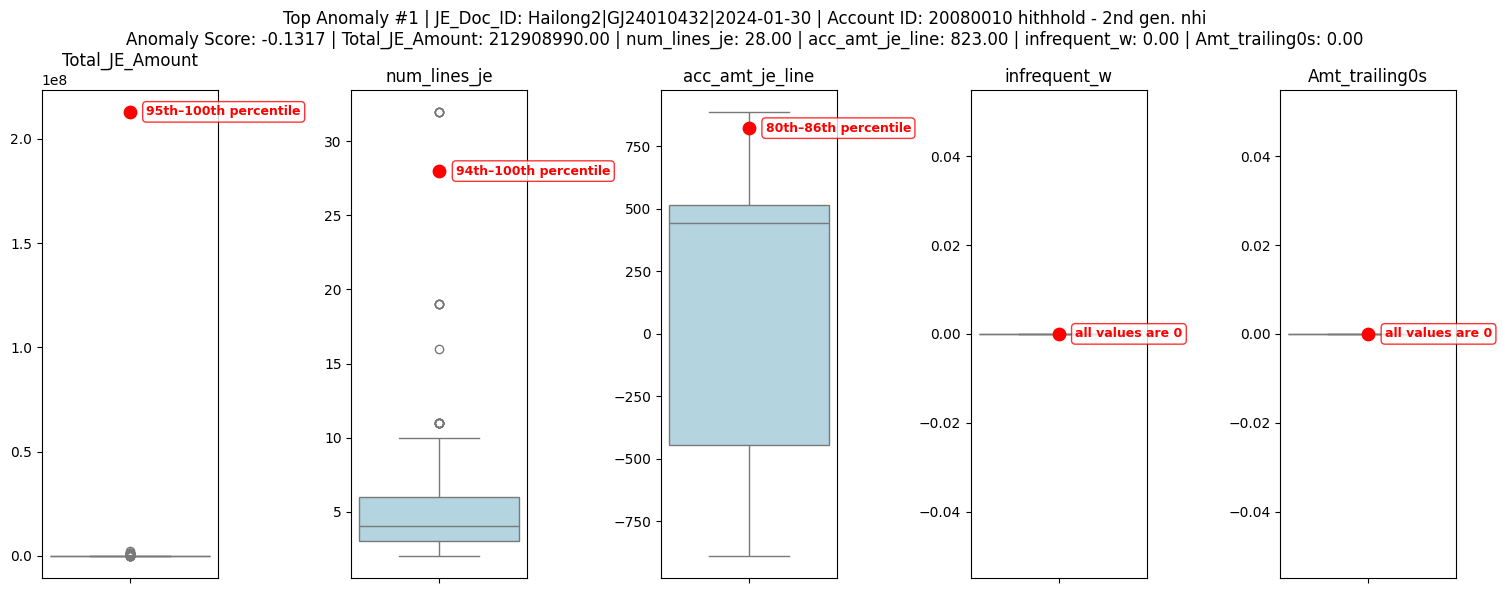

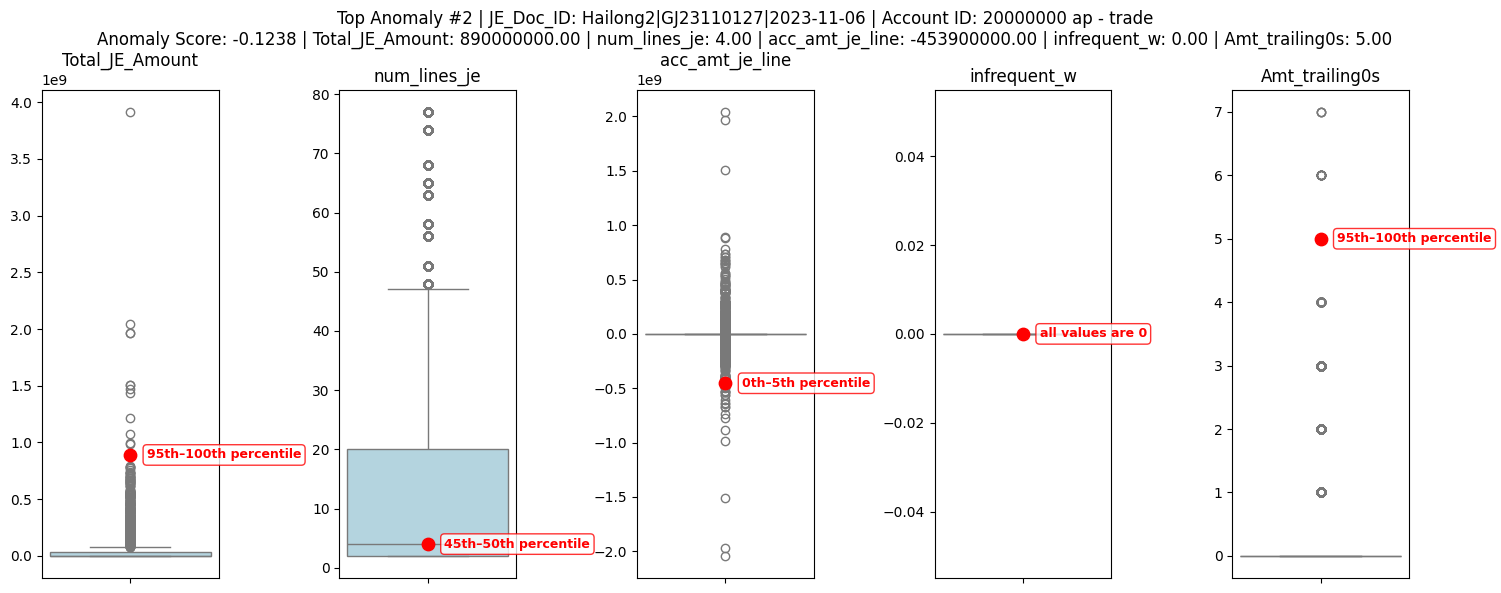

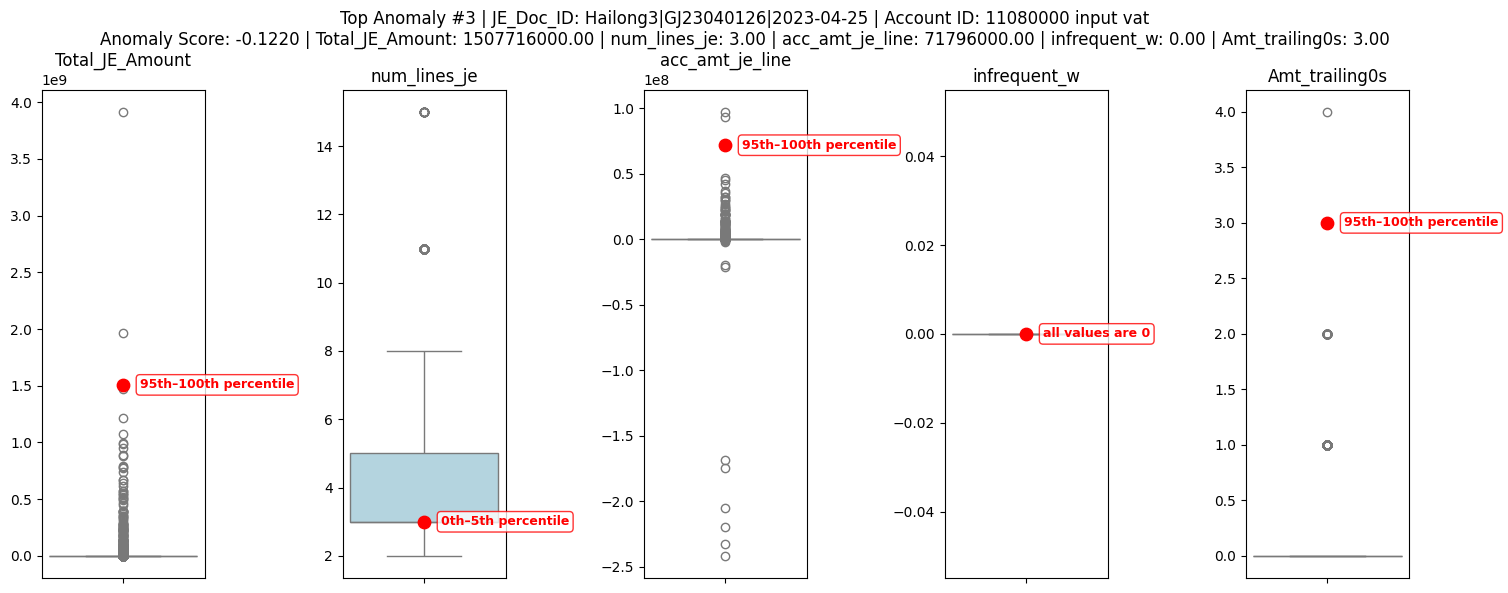

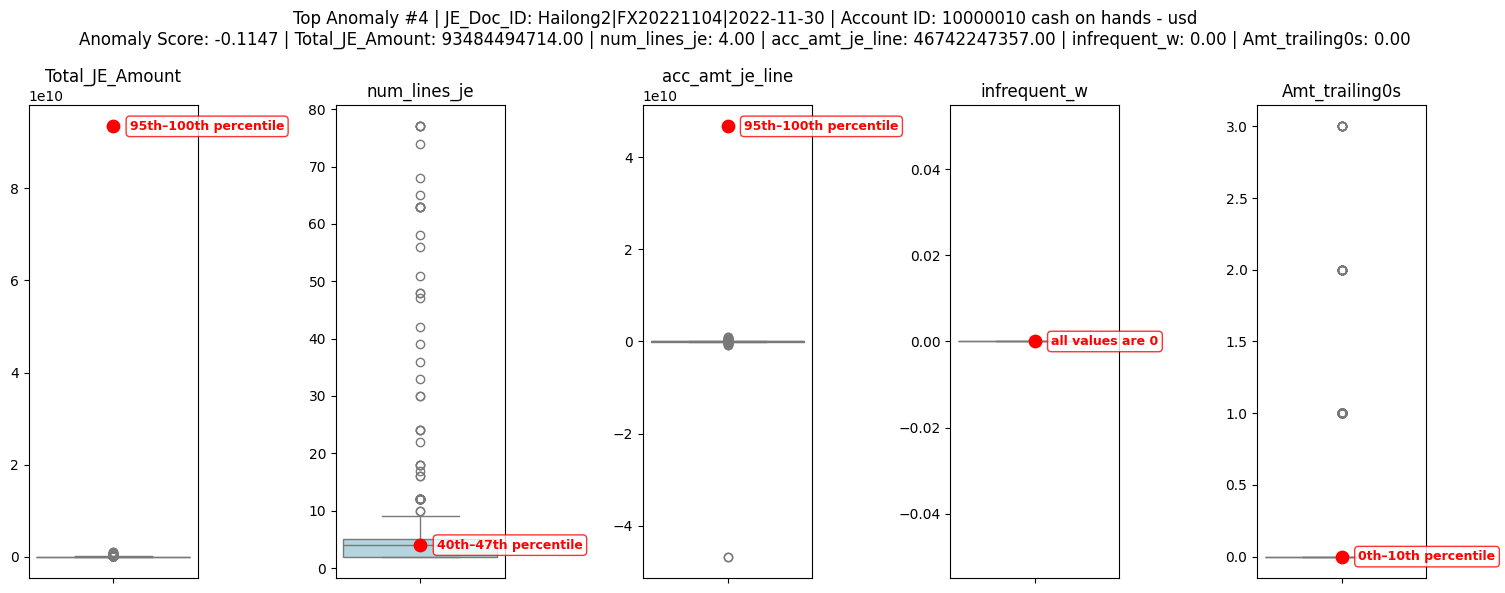

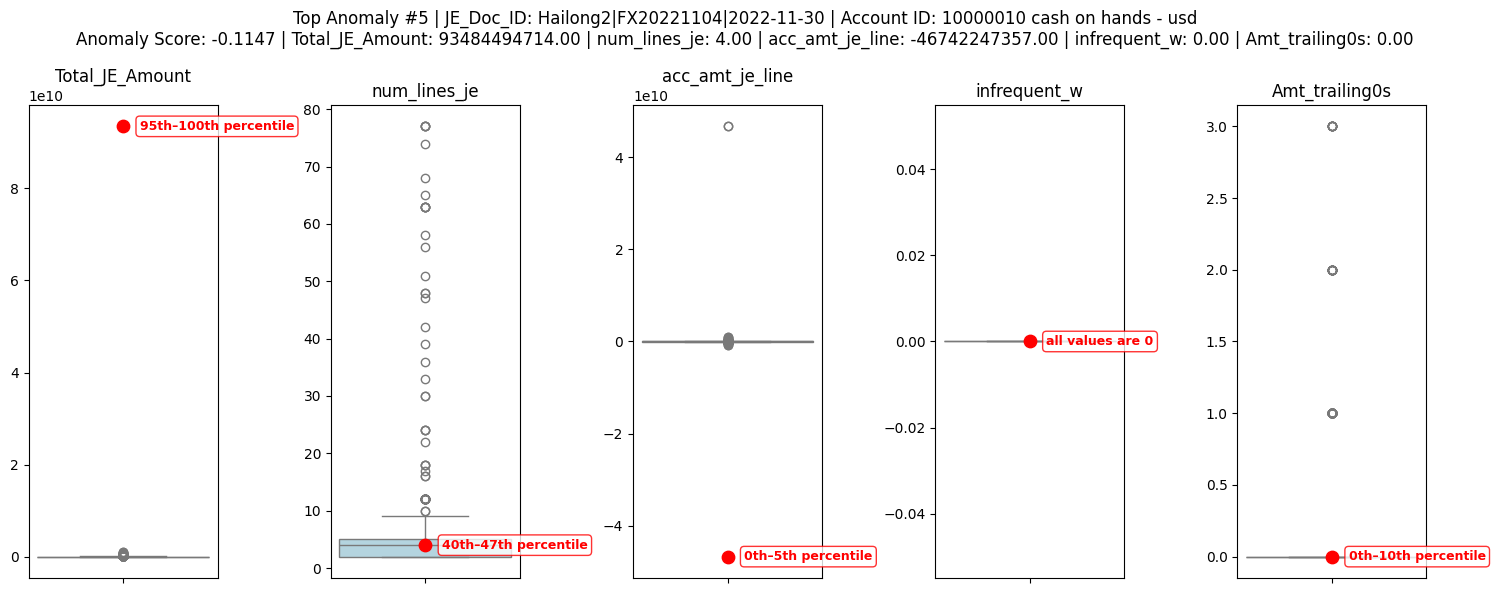

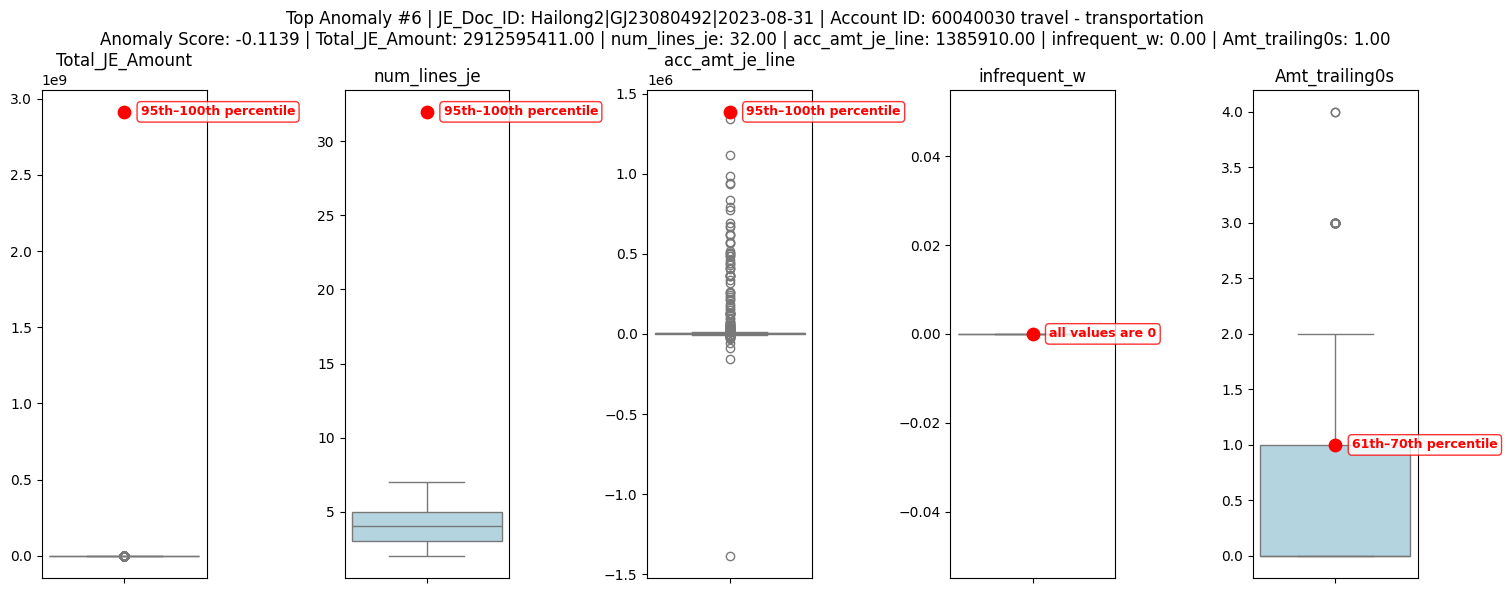

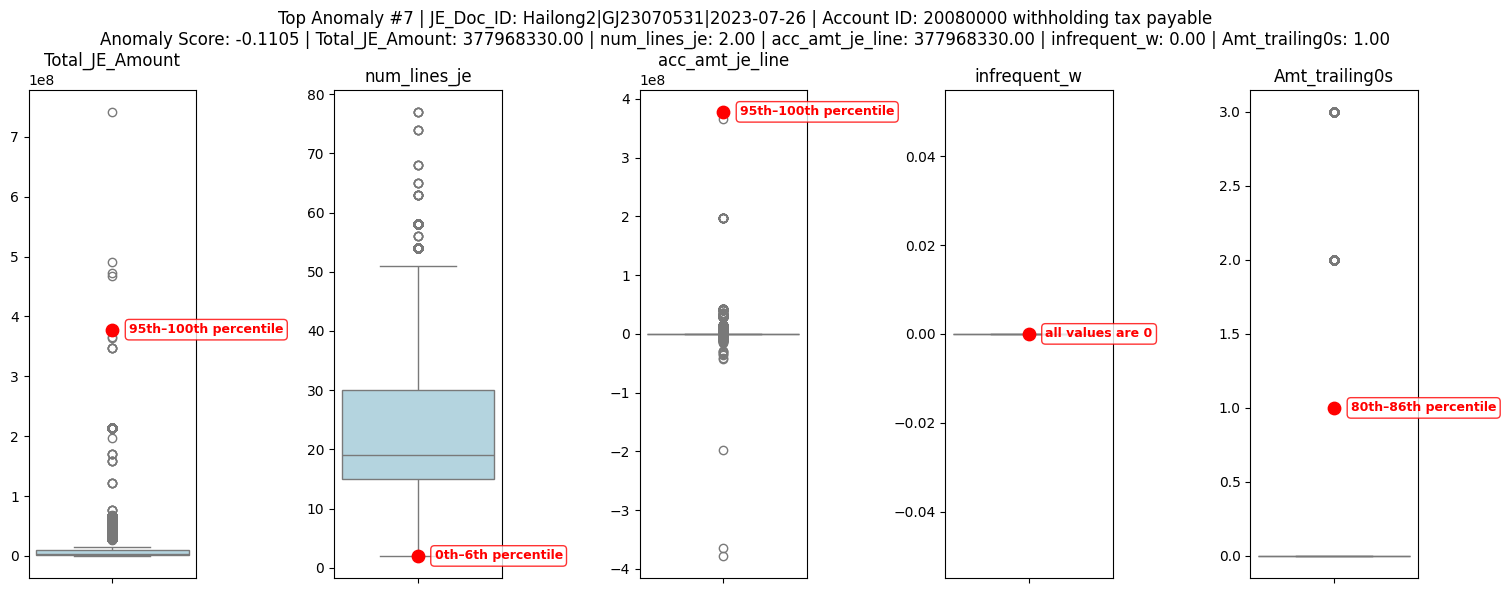

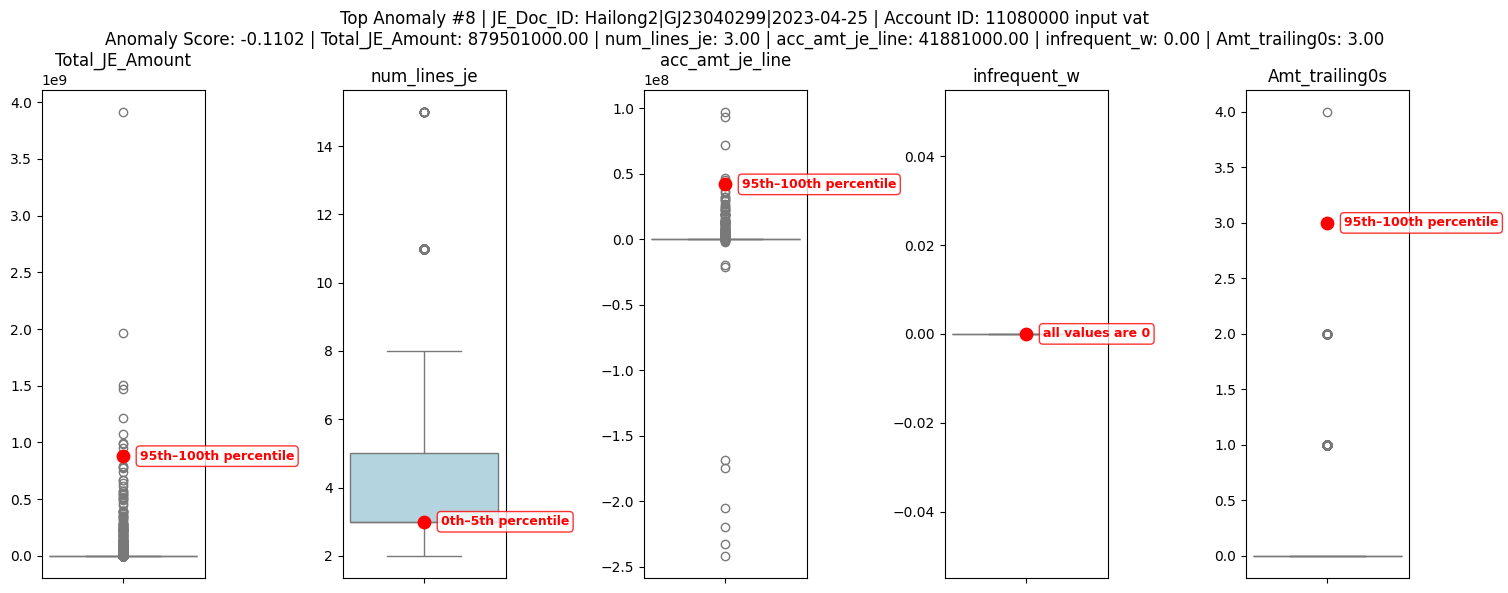

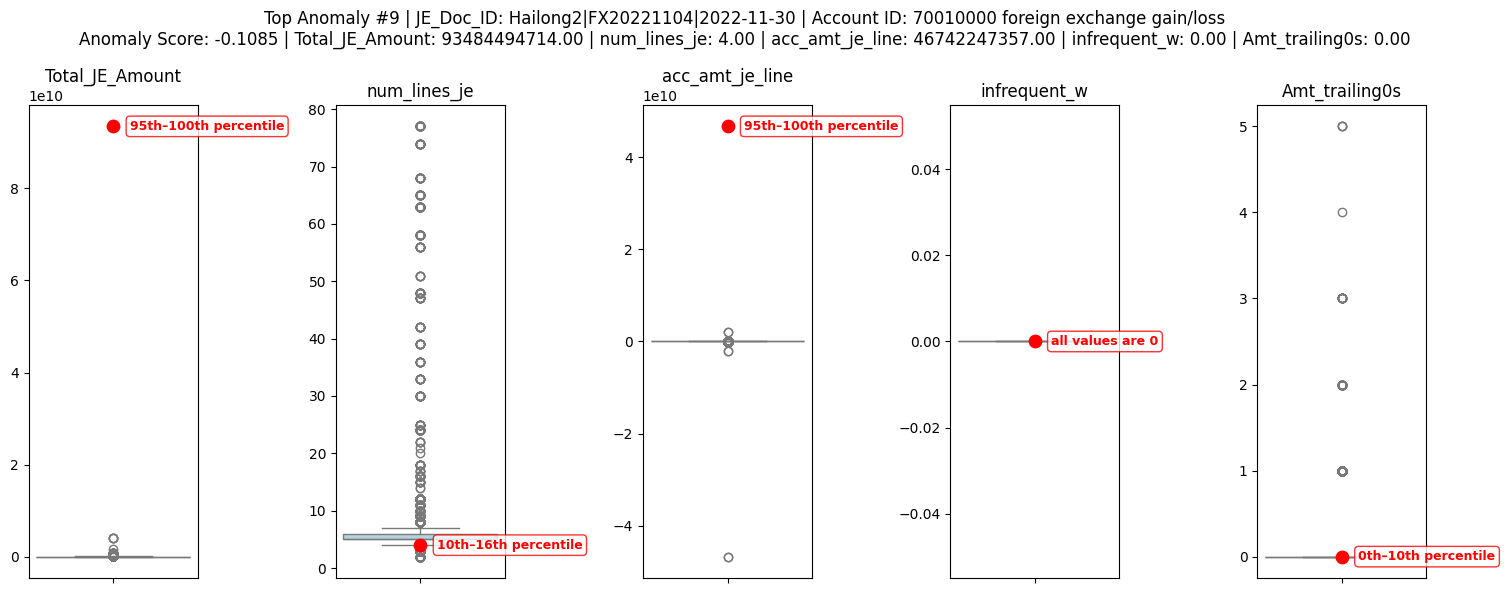

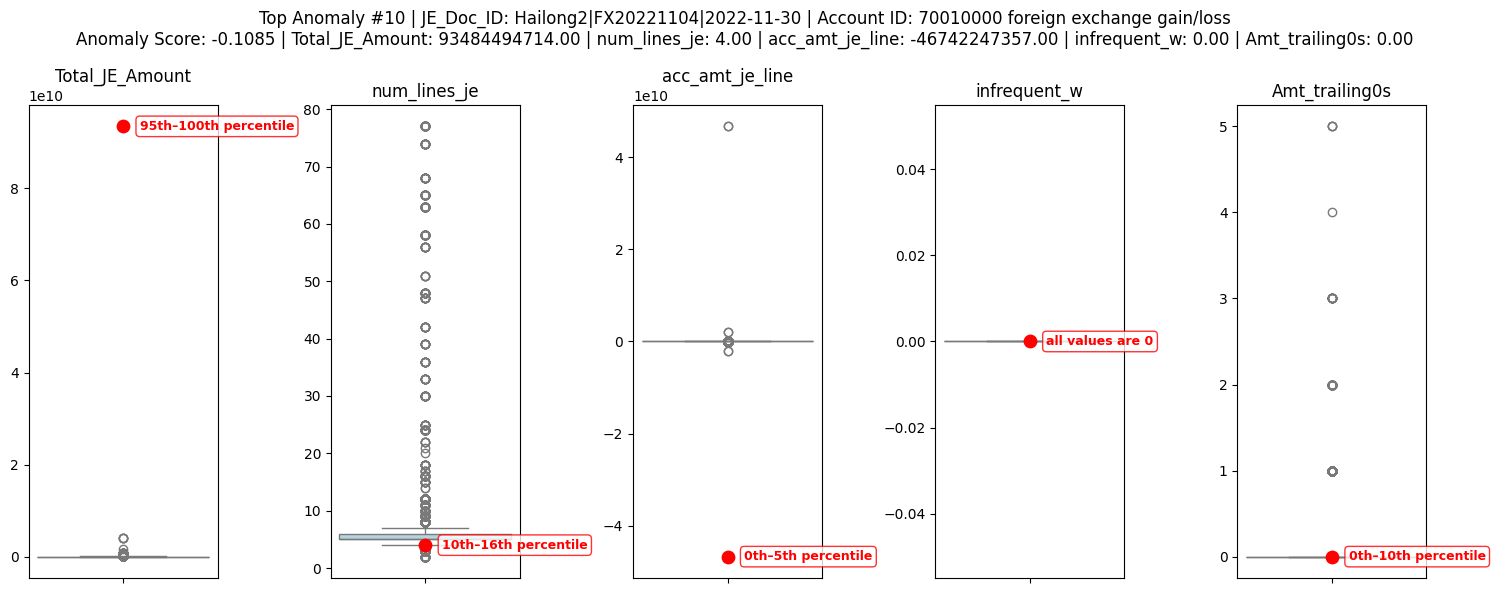

In [138]:
plot_top_anomalies_boxplots(
    result_df=anomalies_e,
    features=features,
    top_n=10
)

## Analysis
1. Find top 10 anomalous JEs
2. Find number of lines in the top 10 anomalous JEs
3. Find within top 100 anomalous lines, how many were also from the top 10 JEs

In [129]:
# Top 10 lines has 1 repeat (Hailong3|GJ23040126|2023-04-25)
top_10 = anomalies.sort_values(by='anomaly_score').head(10)
print(top_10['JE_Doc_ID'].value_counts())

# Get num lines
top_10[['JE_Doc_ID','num_lines_je']]

JE_Doc_ID
Hailong2|FX20221104|2022-11-30    2
Hailong3|GJ23040126|2023-04-25    2
Hailong2|GJ23110127|2023-11-06    1
Hailong2|GJ24010432|2024-01-30    1
Hailong2|GJ23080492|2023-08-31    1
Hailong2|GJ23070531|2023-07-26    1
Hailong2|GJ23040299|2023-04-25    1
Hailong2|GJ23110251|2023-11-09    1
Name: count, dtype: int64


,JE_Doc_ID,num_lines_je
27403,Hailong2|GJ24010432|2024-01-30,28
22350,Hailong2|GJ23110127|2023-11-06,4
40247,Hailong3|GJ23040126|2023-04-25,3
6,Hailong2|FX20221104|2022-11-30,4
18246,Hailong2|GJ23080492|2023-08-31,32
16379,Hailong2|GJ23070531|2023-07-26,2
10851,Hailong2|GJ23040299|2023-04-25,3
8,Hailong2|FX20221104|2022-11-30,4
22779,Hailong2|GJ23110251|2023-11-09,2
40249,Hailong3|GJ23040126|2023-04-25,3


In [130]:
# within top 100 anomalous lines, how many were in top 10 JEs
top_100 = anomalies.sort_values(by='anomaly_score').head(100)

overlap_count = top_100['JE_Doc_ID'].isin(top_10['JE_Doc_ID']).sum()
print(f"Number of rows with JE_Doc_IDs in top 10: {overlap_count}")

# Initialize the column with 0
top_100['is_in_top_10'] = 0

# Mark the first 10 rows as top 10
top_100.iloc[:10, top_100.columns.get_loc('is_in_top_10')] = 1

# top_100

Number of rows with JE_Doc_IDs in top 10: 15


In [131]:
# Convert each row in top_10 to a hashable tuple (handling lists inside)
top_100[top_100['JE_Doc_ID'].isin(top_10['JE_Doc_ID'])].sort_values('JE_Doc_ID')

,JE_Doc_ID,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,...,je_%_frequency,infrequent_w,acc_amt_je_line,Amt_trailing0s,is_anomaly,anomaly_score,anomaly_reason,anomaly_reason_with_percentiles,ISF_PCA_anomalies,is_in_top_10
6,Hailong2|FX20221104|2022-11-30,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000010, 10000010, 70010000, 70010000]",...,"[36.38412620510666, 36.38412620510666, 38.9424...",0,"[46742247357.0, -46742247357.0, -46742247357.0...",0,True,-0.114728,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",0,1
8,Hailong2|FX20221104|2022-11-30,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000010, 10000010, 70010000, 70010000]",...,"[36.38412620510666, 36.38412620510666, 38.9424...",0,"[46742247357.0, -46742247357.0, -46742247357.0...",0,True,-0.108454,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",0,1
9,Hailong2|FX20221104|2022-11-30,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000010, 10000010, 70010000, 70010000]",...,"[36.38412620510666, 36.38412620510666, 38.9424...",0,"[46742247357.0, -46742247357.0, -46742247357.0...",0,True,-0.098277,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",0,0
10851,Hailong2|GJ23040299|2023-04-25,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[16100000, 11080000, 20000000]",...,"[32.46978906825342, 27.448758328367507, 28.906...",0,"[837620000.0, 41881000.0, -879501000.0]","[4, 3, 3]",True,-0.110184,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",1,1
10853,Hailong2|GJ23040299|2023-04-25,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[16100000, 11080000, 20000000]",...,"[32.46978906825342, 27.448758328367507, 28.906...",0,"[837620000.0, 41881000.0, -879501000.0]","[4, 3, 3]",True,-0.104148,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",1,0
16379,Hailong2|GJ23070531|2023-07-26,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[20080000, 10000000]",...,"[31.84701347236932, 31.51261145316944]",0,"[377968330.0, -377968330.0]",1,True,-0.110481,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",1,1
18246,Hailong2|GJ23080492|2023-08-31,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[16100000, 16100000, 16100000, 16100000, 16100...",...,"[32.46978906825342, 32.46978906825342, 32.4697...",0,"[3164486.0, 32130.0, 652744221.0, 288885123.0,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 2, ...",True,-0.113876,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",1,1
22350,Hailong2|GJ23110127|2023-11-06,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[16100000, 16100000, 16100001, 20000000]",...,"[24.846060172881426, 24.846060172881426, 24.65...",0,"[436100000.0, 453900000.0, -436100000.0, -4539...",5,True,-0.123845,"SHAP: Total_JE_Amount, Amt_trailing0s","Total_JE_Amount (too high, 95th–100th percenti...",1,1
22779,Hailong2|GJ23110251|2023-11-09,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000000, 20000000]",...,"[30.239199340095812, 27.09882361878096]",0,"[-890000000.0, 890000000.0]",7,True,-0.106717,"SHAP: Total_JE_Amount, Amt_trailing0s","Total_JE_Amount (too high, 95th–100th percenti...",1,1
22778,Hailong2|GJ23110251|2023-11-09,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000000, 20000000]",...,"[30.239199340095812, 27.09882361878096]",0,"[-890000000.0, 890000000.0]",7,True,-0.071394,"SHAP: Total_JE_Amount, Amt_trailing0s","Total_JE_Amount (too high, 95th–100th percenti...",1,0


In [132]:
# Top 11 lines, top 10 JEs
top_10 = anomalies.sort_values(by='anomaly_score').head(11)
top_10['JE_Doc_ID'].value_counts()

# Get num lines
top_10[['JE_Doc_ID','num_lines_je']]

,JE_Doc_ID,num_lines_je
27403,Hailong2|GJ24010432|2024-01-30,28
22350,Hailong2|GJ23110127|2023-11-06,4
40247,Hailong3|GJ23040126|2023-04-25,3
6,Hailong2|FX20221104|2022-11-30,4
18246,Hailong2|GJ23080492|2023-08-31,32
16379,Hailong2|GJ23070531|2023-07-26,2
10851,Hailong2|GJ23040299|2023-04-25,3
8,Hailong2|FX20221104|2022-11-30,4
22779,Hailong2|GJ23110251|2023-11-09,2
40249,Hailong3|GJ23040126|2023-04-25,3


In [133]:
# within top 100 anomalous lines, how many were in top 10 JEs
top_100 = anomalies.sort_values(by='anomaly_score').head(100)

overlap_count = top_100['JE_Doc_ID'].isin(top_10['JE_Doc_ID']).sum()
print(f"Number of rows with JE_Doc_IDs in top 10: {overlap_count}")

# Initialize the column with 0
top_100['is_in_top_10'] = 0

# Mark the first 10 rows as top 10
top_100.iloc[:11, top_100.columns.get_loc('is_in_top_10')] = 1

# top_100

Number of rows with JE_Doc_IDs in top 10: 16


In [134]:
# Convert each row in top_10 to a hashable tuple (handling lists inside)
top_100[top_100['JE_Doc_ID'].isin(top_10['JE_Doc_ID'])].sort_values('JE_Doc_ID')

,JE_Doc_ID,CompanyName,ExcludeBalanceOnly,PrintReversedEntries,PageGroupNo,PrintOnlyOnePerPage,PrintClosingEntries,PrintOnlyCorrections,EmptyString,No_GLAcc,...,je_%_frequency,infrequent_w,acc_amt_je_line,Amt_trailing0s,is_anomaly,anomaly_score,anomaly_reason,anomaly_reason_with_percentiles,ISF_PCA_anomalies,is_in_top_10
6,Hailong2|FX20221104|2022-11-30,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000010, 10000010, 70010000, 70010000]",...,"[36.38412620510666, 36.38412620510666, 38.9424...",0,"[46742247357.0, -46742247357.0, -46742247357.0...",0,True,-0.114728,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",0,1
8,Hailong2|FX20221104|2022-11-30,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000010, 10000010, 70010000, 70010000]",...,"[36.38412620510666, 36.38412620510666, 38.9424...",0,"[46742247357.0, -46742247357.0, -46742247357.0...",0,True,-0.108454,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",0,1
9,Hailong2|FX20221104|2022-11-30,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000010, 10000010, 70010000, 70010000]",...,"[36.38412620510666, 36.38412620510666, 38.9424...",0,"[46742247357.0, -46742247357.0, -46742247357.0...",0,True,-0.098277,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",0,0
10851,Hailong2|GJ23040299|2023-04-25,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[16100000, 11080000, 20000000]",...,"[32.46978906825342, 27.448758328367507, 28.906...",0,"[837620000.0, 41881000.0, -879501000.0]","[4, 3, 3]",True,-0.110184,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",1,1
10853,Hailong2|GJ23040299|2023-04-25,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[16100000, 11080000, 20000000]",...,"[32.46978906825342, 27.448758328367507, 28.906...",0,"[837620000.0, 41881000.0, -879501000.0]","[4, 3, 3]",True,-0.104148,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",1,0
15810,Hailong2|GJ23070335|2023-07-25,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[20080000, 16100000, 16100000, 16100001]",...,"[31.84701347236932, 32.46978906825342, 32.4697...",0,"[-377968330.0, 363835122.0, 377968330.0, -3638...","[1, 0, 1, 0]",True,-0.105126,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",1,1
16379,Hailong2|GJ23070531|2023-07-26,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[20080000, 10000000]",...,"[31.84701347236932, 31.51261145316944]",0,"[377968330.0, -377968330.0]",1,True,-0.110481,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",1,1
18246,Hailong2|GJ23080492|2023-08-31,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[16100000, 16100000, 16100000, 16100000, 16100...",...,"[32.46978906825342, 32.46978906825342, 32.4697...",0,"[3164486.0, 32130.0, 652744221.0, 288885123.0,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 2, ...",True,-0.113876,"SHAP: Total_JE_Amount, acc_amt_je_line","Total_JE_Amount (too high, 95th–100th percenti...",1,1
22350,Hailong2|GJ23110127|2023-11-06,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[16100000, 16100000, 16100001, 20000000]",...,"[24.846060172881426, 24.846060172881426, 24.65...",0,"[436100000.0, 453900000.0, -436100000.0, -4539...",5,True,-0.123845,"SHAP: Total_JE_Amount, Amt_trailing0s","Total_JE_Amount (too high, 95th–100th percenti...",1,1
22779,Hailong2|GJ23110251|2023-11-09,Hailong2,FALSE,FALSE,1,FALSE,FALSE,FALSE,None,"[10000000, 20000000]",...,"[30.239199340095812, 27.09882361878096]",0,"[-890000000.0, 890000000.0]",7,True,-0.106717,"SHAP: Total_JE_Amount, Amt_trailing0s","Total_JE_Amount (too high, 95th–100th percenti...",1,1
